# EXPERIMENT OUTLINE

1. Check for Imbalance
2. Compare Results for Sampling and Non-Sampling by Accuracy
3. Calculate Metrics (F1 Score, Recall, Precision, and Accuracy) for Each Animal for Sampled Data
4. Confusion Matrix Visualisation
5. Make a prediction of Labels
5. Further Metrics(cross validation)

## 1a.Check for imbalance

In [128]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import learning_curve
import scikitplot as skplt
# plt.rcParams.update({'font.size': 14,
#                      'axes.titlesize': 16,
#                      'axes.labelsize': 14,
#                      'xtick.labelsize': 13,
#                      'ytick.labelsize': 13,
#                      'legend.fontsize': 13})

In [2]:
def check_balance(file_path):
    # Load the csv file
    df = pd.read_csv(file_path, header=None)

    # Get the counts of each class (animal)
    class_counts = df[0].value_counts()

    print(f"Class counts in {file_path}:")
    print(class_counts)
    print()

# Provide the paths to your CSV files
files = [
    'Pigs_49651_960_540_500f_Labels.csv',
    'Koi_5652_952_540_Labels.csv',
    'Pigeons_8234_1280_720_Labels.csv',
    'Pigeons_4927_960_540_600f_Labels.csv',
    'Pigeons_29033_960_540_300f_Labels.csv'
]

for file in files:
    check_balance(file)


Class counts in Pigs_49651_960_540_500f_Labels.csv:
16    484
17    395
11    378
2     351
10    351
12    338
5     330
18    330
1     304
9     301
7     298
13    264
6     246
14    239
0     237
20    199
8     188
19    175
3     144
15    142
4     138
21     90
Name: 0, dtype: int64

Class counts in Koi_5652_952_540_Labels.csv:
6    265
8    259
4    232
1    225
5    161
3    152
2    145
0    102
7     94
Name: 0, dtype: int64

Class counts in Pigeons_8234_1280_720_Labels.csv:
2     443
1     441
3     441
9     437
11    436
0     361
4     354
6     352
8     346
7     271
5     227
10    225
12    225
Name: 0, dtype: int64

Class counts in Pigeons_4927_960_540_600f_Labels.csv:
11    444
13    423
1     266
8     258
7     246
3     242
5     233
2     175
0     160
6     151
4     104
9      65
10     57
12     53
Name: 0, dtype: int64

Class counts in Pigeons_29033_960_540_300f_Labels.csv:
1     298
14    297
5     297
7     286
0     251
11    248
8     248
16    247
4

1b. The data appears to be imbalanced. While the spread between the most frequent and least frequent class (individual animal) varies between the videos, there is a notable disparity in all of them.

For example, in 'Pigs_49651_960_540_500f_Labels.csv', the class represented by '16' has 484 instances while the class represented by '21' has only 90 instances. Similarly, in 'Pigeons_29033_960_540_300f_Labels.csv', the class represented by '1' has 298 instances while the class represented by '12' has only 44 instances.

## 2. Compare results of Sampling with non sampled data

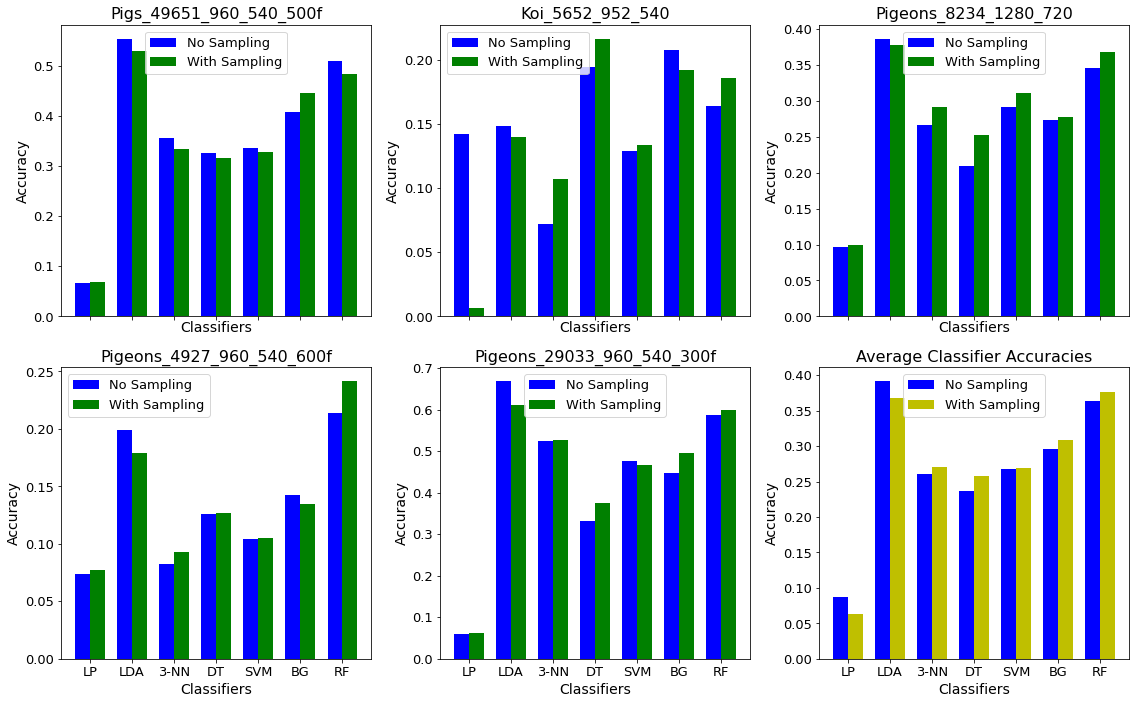

In [70]:
# Ensure reproducibility
np.random.seed(42)

# Ignore FutureWarnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Directory path
directory_path = r'C:\Users\USER\Desktop\Advanced Data Science\ICE-4701 Advanced Machine Learning S2\Animal identification\AnimalDataBase\\'

# Video names and respective training and testing sizes
videos = {
    'Pigs_49651_960_540_500f': (2710, 3212),
    'Koi_5652_952_540': (916, 719),
    'Pigeons_8234_1280_720': (2268, 2291),
    'Pigeons_4927_960_540_600f': (1574, 1303),
    'Pigeons_29033_960_540_300f': (2148, 2241)
}

# Initialize classifiers
classifiers = {
    'Largest Prior': None,
    'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
    '3-nn': KNeighborsClassifier(n_neighbors=3),
    'Decision Tree': DecisionTreeClassifier(),
    'SVM': SVC(kernel='linear'),
    'Bagging': BaggingClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=100)
}

def load_data_sampling(video_name, feature, directory_path, training_size, testing_size):
    df = pd.read_csv(f'{directory_path}{video_name}_{feature}.csv', header=None)
    labels = pd.read_csv(f'{directory_path}{video_name}_Labels.csv', header=None)

    X_train = df[:training_size].copy()
    y_train = labels[:training_size].copy()

    X_train['Label'] = y_train

    # Find the maximum count among the classes
    max_size = X_train['Label'].value_counts().max()

    # Create a list to collect the DataFrames
    lst = [X_train]

    # Iterate over each class
    for class_index, group in X_train.groupby('Label'):
        # Oversample the groups with less than max_size
        lst.append(group.sample(max_size-len(group), replace=True))

    # Concatenate the DataFrames in the list
    df_upsampled = pd.concat(lst)

    y_train = df_upsampled['Label']
    X_train = df_upsampled.drop('Label', axis=1)

    X_test = df[training_size:training_size + testing_size]
    y_test = labels[training_size:training_size + testing_size]

    return X_train, y_train, X_test, y_test


def load_data(video_name, directory_path, training_size, testing_size):
    features = ['DataRGB', 'DataHOG', 'DataH10', 'DataLBP']
    dataframes = []
    
    for feature in features:
        df = pd.read_csv(f'{directory_path}{video_name}_{feature}.csv', header=None)
        dataframes.append(df)

    data = pd.concat(dataframes, axis=1)

    labels = pd.read_csv(f'{directory_path}{video_name}_Labels.csv', header=None)

    X_train = data[:training_size]
    y_train = labels[:training_size]

    X_test = data[training_size:training_size + testing_size]
    y_test = labels[training_size:training_size + testing_size]
    
    # Combine X_train and y_train for resampling
    train_data = pd.concat([X_train, y_train], axis=1)

    # Split train_data into classes
    class_data = [train_data[train_data.iloc[:,-1]==label] for label in np.unique(y_train)]

    # Find the size of the largest class
    max_len = max(len(class_data_i) for class_data_i in class_data)

    # Upsample all classes to be the same size as the largest class
    upsampled_data = [class_data_i.sample(n=max_len, replace=True, random_state=123) for class_data_i in class_data]
    
    # Combine all upsampled classes
    train_upsampled = pd.concat(upsampled_data)
    
    # Split upsampled training data back into X_train_resampled and y_train_resampled
    X_train_resampled = train_upsampled.iloc[:,:-1]
    y_train_resampled = train_upsampled.iloc[:,-1]
    
    return X_train_resampled, y_train_resampled, X_test, y_test

def load_data_no_sampling(video_name, directory_path, training_size, testing_size):
    features = ['DataRGB', 'DataHOG', 'DataH10', 'DataLBP']
    dataframes = []
    
    for feature in features:
        df = pd.read_csv(f'{directory_path}{video_name}_{feature}.csv')
        dataframes.append(df)

    data = pd.concat(dataframes, axis=1)

    labels = pd.read_csv(f'{directory_path}{video_name}_Labels.csv')

    X_train = data[:training_size]
    y_train = labels[:training_size]

    X_test = data[training_size:training_size + testing_size]
    y_test = labels[training_size:training_size + testing_size]

    return X_train, y_train, X_test, y_test

def largest_prior(y):
    return y.value_counts().idxmax()

def calculate_results(X_train, y_train, X_test, y_test):
    results = {}
    for classifier_name, classifier in classifiers.items():
        if classifier_name == 'Largest Prior':
            y_pred = [largest_prior(y_train)] * len(y_test)
            score = np.mean(y_pred == y_test.values.ravel())
        else:
            classifier.fit(X_train, y_train.values.ravel())
            score = classifier.score(X_test, y_test)

        results[classifier_name] = score
    return results


def calculate_results_no_sampling(X_train, y_train, X_test, y_test):
    results = {}
    for classifier_name, classifier in classifiers.items():
        if classifier_name == 'Largest Prior':
            y_pred = [largest_prior(y_train)] * len(y_test)
        else:
            classifier.fit(X_train, y_train.values.ravel())
            y_pred = classifier.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        results[classifier_name] = accuracy
    return results


def plot_results(video_name, results_no_sampling, results_sampling, subplot):
    classifiers = list(results_no_sampling.keys())
    accuracies_no_sampling = list(results_no_sampling.values())
    accuracies_sampling = list(results_sampling.values())
    
    bar_width = 0.35

    bar1 = np.arange(len(classifiers))
    bar2 = [x + bar_width for x in bar1]

    subplot.bar(bar1, accuracies_no_sampling, color='b', width=bar_width, label='No Sampling')
    subplot.bar(bar2, accuracies_sampling, color='g', width=bar_width, label='With Sampling')

    subplot.set_xlabel('Classifiers')
    subplot.set_ylabel('Accuracy')
    subplot.set_title(f'Classifier accuracies for {video_name}')
    subplot.set_xticks(bar1 + bar_width / 2)
    subplot.set_xticklabels(classifiers)

    subplot.legend()

# Create a 2x3 subplot grid
fig, axes = plt.subplots(2, 3, figsize=(16, 10), sharex=True)

average_results_no_sampling = {}
average_results_sampling = {}

bar_width = 0.35

for i, (video_name, sizes) in enumerate(videos.items()):
    training_size = sizes[0] // 2  # Use the first half of the video for training
    testing_size = sizes[0] - training_size  # Use the remaining half of the video for testing


    X_train_no_sampling, y_train_no_sampling, X_test_no_sampling, y_test_no_sampling = load_data_no_sampling(video_name, directory_path, training_size, testing_size)
    X_train_sampling, y_train_sampling, X_test_sampling, y_test_sampling = load_data(video_name, directory_path, training_size, testing_size)

    results_no_sampling = calculate_results_no_sampling(X_train_no_sampling, y_train_no_sampling, X_test_no_sampling, y_test_no_sampling)
    results_sampling = calculate_results(X_train_sampling, y_train_sampling, X_test_sampling, y_test_sampling)

    average_results_no_sampling[video_name] = results_no_sampling
    average_results_sampling[video_name] = results_sampling

    # Plot the results in the corresponding subplot
    ax_row = i // 3
    ax_col = i % 3
    ax = axes[ax_row, ax_col]

    plot_results(video_name, results_no_sampling, results_sampling, ax)
    ax.set_title(video_name)
    ax.set_xticks(np.arange(len(classifiers)) + bar_width / 2)
    ax.set_xticklabels(['LP', 'LDA', '3-NN', 'DT', 'SVM', 'BG', 'RF'])

# Calculate average accuracies across all videos
average_accuracies_no_sampling = {}
average_accuracies_sampling = {}

for classifier_name in classifiers.keys():
    average_accuracies_no_sampling[classifier_name[0] + classifier_name[-1]] = np.mean([results[classifier_name] for results in average_results_no_sampling.values()])
    average_accuracies_sampling[classifier_name[0] + classifier_name[-1]] = np.mean([results[classifier_name] for results in average_results_sampling.values()])

# Plot the average accuracies
ax_average = axes[-1, -1]

bar1 = np.arange(len(classifiers))
bar2 = [x + bar_width for x in bar1]
# Set shared x-label

ax_average.bar(bar1, list(average_accuracies_no_sampling.values()), color='b', width=bar_width, label='No Sampling')
ax_average.bar(bar2, list(average_accuracies_sampling.values()), color='y', width=bar_width, label='With Sampling')

ax_average.set_xlabel('Classifiers')
ax_average.set_ylabel('Accuracy')
ax_average.set_title('Average Classifier Accuracies')
ax_average.set_xticks(bar1 + bar_width / 2)
ax_average.set_xticklabels(['LP', 'LDA', '3-NN', 'DT', 'SVM', 'BG', 'RF'])

ax_average.legend()
# Saves the figure as a high resolution PNG image
plt.savefig('barchart.png',dpi = 800)
# fig.show()
plt.tight_layout()
plt.show()


## 3. Calculate Metrics (F1 Score, Recall, Precision, and Accuracy) for Each Animal for Sampled Data for each feature

The models will be trained for each feature on the first half of each video and evaluated on the second half for individual animal recognition.

In [94]:
# Ensure reproducibility
np.random.seed(42)

# Ignore FutureWarnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Directory path
directory_path = r'C:\Users\USER\Desktop\Advanced Data Science\ICE-4701 Advanced Machine Learning S2\Animal identification\AnimalDataBase\\'

# Directory to save CSV results
results_directory = r'C:\Users\USER\Desktop\Advanced Data Science\ICE-4701 Advanced Machine Learning S2\Animal identification\AnimalDataBase\test6\\'

# Video names and respective training and testing sizes
videos = {
    'Pigs_49651_960_540_500f': (2710, 3212),
    'Koi_5652_952_540': (916, 719),
    'Pigeons_8234_1280_720': (2268, 2291),
    'Pigeons_4927_960_540_600f': (1574, 1303),
    'Pigeons_29033_960_540_300f': (2148, 2241)
}



# Initialize classifiers
classifiers = {
    'Largest Prior': None,
    'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
    '3-nn': KNeighborsClassifier(n_neighbors=3),
    'Decision Tree': DecisionTreeClassifier(),
    'SVM': SVC(kernel='linear'),
    'Bagging': BaggingClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=100)
}

def load_data_sampling(video_name, feature, directory_path, training_size, testing_size):
    df = pd.read_csv(f'{directory_path}{video_name}_{feature}.csv', header=None)
    labels = pd.read_csv(f'{directory_path}{video_name}_Labels.csv', header=None)

    X_train = df[:training_size].copy()
    y_train = labels[:training_size].copy()

    X_train['Label'] = y_train

    # Find the maximum count among the classes
    max_size = X_train['Label'].value_counts().max()

    # Create a list to collect the DataFrames
    lst = [X_train]

    # Iterate over each class
    for class_index, group in X_train.groupby('Label'):
        # Oversample the groups with less than max_size
        lst.append(group.sample(max_size-len(group), replace=True))

    # Concatenate the DataFrames in the list
    df_upsampled = pd.concat(lst)

    y_train = df_upsampled['Label']
    X_train = df_upsampled.drop('Label', axis=1)

    X_test = df[training_size:training_size + testing_size]
    y_test = labels[training_size:training_size + testing_size]

    return X_train, y_train, X_test, y_test

def largest_prior(y):
    return y.value_counts().idxmax()

def calculate_results(X_train, y_train, X_test, y_test):
    results = {}
    for classifier_name, classifier in classifiers.items():
        if classifier_name == 'Largest Prior':
            y_pred = [largest_prior(y_train)] * len(y_test)
        else:
            classifier.fit(X_train, y_train)
            y_pred = classifier.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        
        results[classifier_name] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}
    return results

def save_results_to_csv(video_name, feature, results, results_directory):
    # Create DataFrame from results
    df_results = pd.DataFrame(results).transpose()
    
    # Add classifier name, video_name and feature columns
    df_results['Classifier'] = df_results.index
    df_results['Video'] = video_name
    df_results['Feature'] = feature

    # Reorder columns
    df_results = df_results[['Classifier', 'Video', 'Feature', 'Accuracy', 'Precision', 'Recall', 'F1 Score']]
    
    # Generate CSV file path based on animal type
    animal_type = video_name.split('_')[0]
    animal_name = video_name.split('_')[1:]
    animal_file_name = '_'.join(animal_name)
    results_file = os.path.join(results_directory, f'{animal_type}_{animal_file_name}_results.csv')

    # Append DataFrame to CSV
    if os.path.exists(results_file):
        df_results.to_csv(results_file, mode='a', header=False, index=False)
    else:
        df_results.to_csv(results_file, index=False)

def print_results(video_name, feature, results):
    print(f"\nResults for video: {video_name} with feature: {feature}")
    for classifier_name, metrics in results.items():
        print(f"\n{classifier_name}:")
        for metric_name, metric_value in metrics.items():
            print(f'  {metric_name}: {metric_value * 100}%')

# # Create results directory if it doesn't exist
if not os.path.exists(results_directory):
    os.makedirs(results_directory)

for video_name, sizes in videos.items():
    training_size = sizes[0] // 2  # Use the first half of the video for training
    testing_size = sizes[0] - training_size  # Use the remaining half of the video for testing

    print("\n" + "="*50)  # Print line separator
    print(f"Processing video: {video_name}")
    print("="*50)
    
    for feature in ['DataRGB', 'DataHOG', 'DataH10', 'DataLBP']:
        print(f"\nProcessing feature: {feature}")
        X_train, y_train, X_test, y_test = load_data_sampling(video_name, feature, directory_path, training_size, testing_size)
        results = calculate_results(X_train, y_train, X_test, y_test)
        print_results(video_name, feature, results)
        # Plot ROC curves
        
        # Save results to CSV
#         save_results_to_csv(video_name, feature, results, results_directory)
        # Get predicted probabilities for the classifier of interest
       


Processing video: Pigs_49651_960_540_500f

Processing feature: DataRGB

Results for video: Pigs_49651_960_540_500f with feature: DataRGB

Largest Prior:
  Accuracy: 6.715867158671587%
  Precision: 0.4510287169292358%
  Recall: 6.715867158671587%
  F1 Score: 0.8452889508148196%

Linear Discriminant Analysis:
  Accuracy: 48.487084870848705%
  Precision: 56.54101892468134%
  Recall: 48.487084870848705%
  F1 Score: 45.813620126221686%

3-nn:
  Accuracy: 39.557195571955724%
  Precision: 43.41108278439129%
  Recall: 39.557195571955724%
  F1 Score: 36.86242306214337%

Decision Tree:
  Accuracy: 33.72693726937269%
  Precision: 38.90513783053639%
  Recall: 33.72693726937269%
  F1 Score: 32.72441890774612%

SVM:
  Accuracy: 36.23616236162361%
  Precision: 40.923829936572325%
  Recall: 36.23616236162361%
  F1 Score: 33.63663576112287%

Bagging:
  Accuracy: 30.553505535055354%
  Precision: 33.08817288024044%
  Recall: 30.553505535055354%
  F1 Score: 28.165734581592776%

Random Forest:
  Accuracy:


Results for video: Pigeons_8234_1280_720 with feature: DataRGB

Largest Prior:
  Accuracy: 3.3509700176366843%
  Precision: 0.112290000591%
  Recall: 3.3509700176366843%
  F1 Score: 0.21729839704811263%

Linear Discriminant Analysis:
  Accuracy: 38.447971781305114%
  Precision: 42.24320551476715%
  Recall: 38.447971781305114%
  F1 Score: 36.268357136419894%

3-nn:
  Accuracy: 29.01234567901235%
  Precision: 33.42289084369434%
  Recall: 29.01234567901235%
  F1 Score: 29.763180776786296%

Decision Tree:
  Accuracy: 17.548500881834215%
  Precision: 20.31612208292245%
  Recall: 17.548500881834215%
  F1 Score: 17.348375719843066%

SVM:
  Accuracy: 17.636684303350968%
  Precision: 19.193056055755537%
  Recall: 17.636684303350968%
  F1 Score: 17.352243018472933%

Bagging:
  Accuracy: 23.28042328042328%
  Precision: 25.316621431202215%
  Recall: 23.28042328042328%
  F1 Score: 22.34241566430738%

Random Forest:
  Accuracy: 27.954144620811288%
  Precision: 29.427824258306735%
  Recall: 27.95414


Results for video: Pigeons_29033_960_540_300f with feature: DataRGB

Largest Prior:
  Accuracy: 6.145251396648044%
  Precision: 0.3776411472800474%
  Recall: 6.145251396648044%
  F1 Score: 0.7115554248750366%

Linear Discriminant Analysis:
  Accuracy: 63.50093109869647%
  Precision: 70.32279219293326%
  Recall: 63.50093109869647%
  F1 Score: 62.17391373676592%

3-nn:
  Accuracy: 59.12476722532588%
  Precision: 64.90820407831251%
  Recall: 59.12476722532588%
  F1 Score: 58.21876151220774%

Decision Tree:
  Accuracy: 35.47486033519553%
  Precision: 39.69661888982603%
  Recall: 35.47486033519553%
  F1 Score: 33.6253220326671%

SVM:
  Accuracy: 45.15828677839851%
  Precision: 47.62533909227431%
  Recall: 45.15828677839851%
  F1 Score: 41.830824932385276%

Bagging:
  Accuracy: 47.95158286778399%
  Precision: 52.195590665939875%
  Recall: 47.95158286778399%
  F1 Score: 44.27924695327733%

Random Forest:
  Accuracy: 61.1731843575419%
  Precision: 65.36713057690184%
  Recall: 61.1731843575419

## Confusion Matrix (Metrics) Visualisation

In [107]:
def plot_confusion_matrix(y_true, y_pred, title):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(1,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()



Processing video: Pigs_49651_960_540_500f

Processing feature: DataRGB


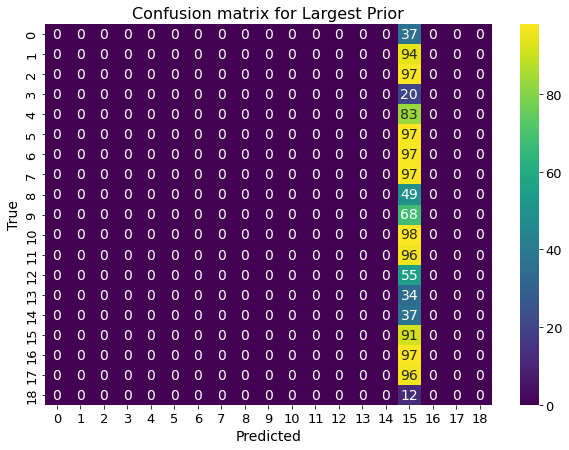

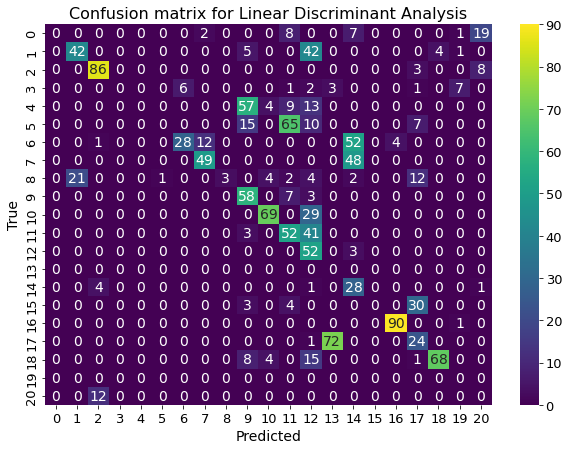

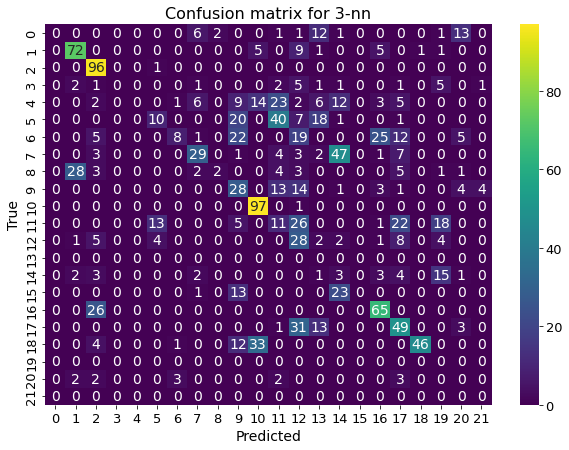

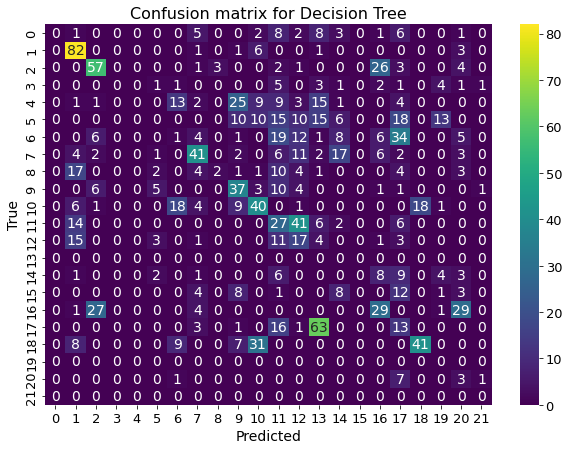

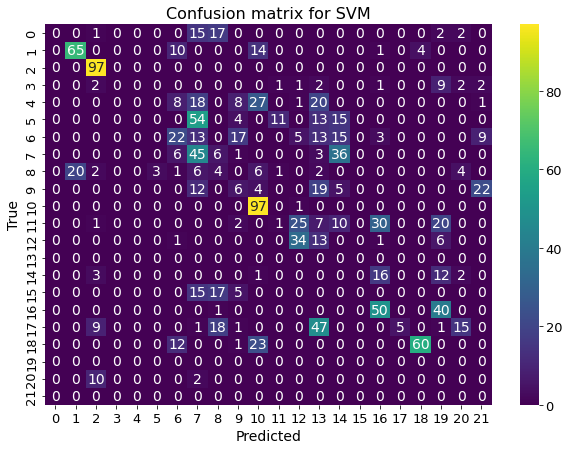

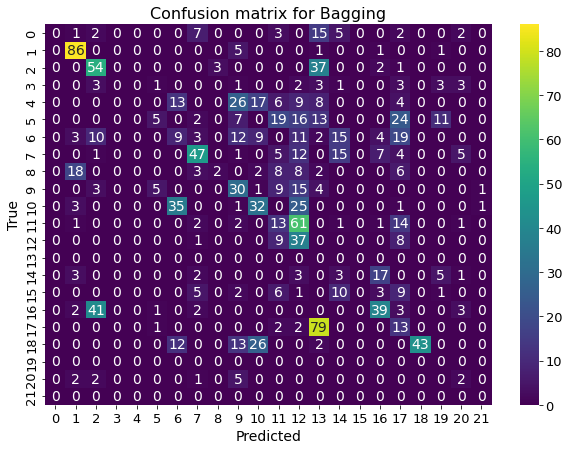

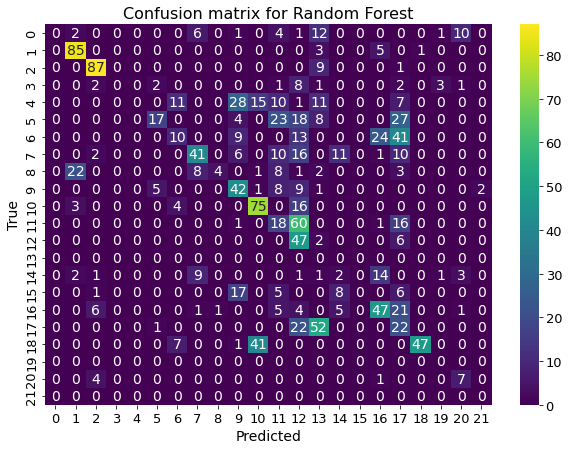


Results for video: Pigs_49651_960_540_500f with feature: DataRGB

Largest Prior:
  Accuracy: 6.715867158671587%
  Precision: 0.4510287169292358%
  Recall: 6.715867158671587%
  F1 Score: 0.8452889508148196%

Linear Discriminant Analysis:
  Accuracy: 47.89667896678967%
  Precision: 53.102027698715105%
  Recall: 47.89667896678967%
  F1 Score: 45.624551832101375%

3-nn:
  Accuracy: 40.14760147601476%
  Precision: 43.934228292996984%
  Recall: 40.14760147601476%
  F1 Score: 37.37348584190653%

Decision Tree:
  Accuracy: 28.782287822878228%
  Precision: 28.180328628100384%
  Recall: 28.782287822878228%
  F1 Score: 27.053152951224412%

SVM:
  Accuracy: 35.86715867158672%
  Precision: 39.90093690783213%
  Recall: 35.86715867158672%
  F1 Score: 33.49216400414401%

Bagging:
  Accuracy: 30.627306273062732%
  Precision: 35.67194603704426%
  Recall: 30.627306273062732%
  F1 Score: 30.051235012883527%

Random Forest:
  Accuracy: 40.66420664206642%
  Precision: 45.78838159545885%
  Recall: 40.664206

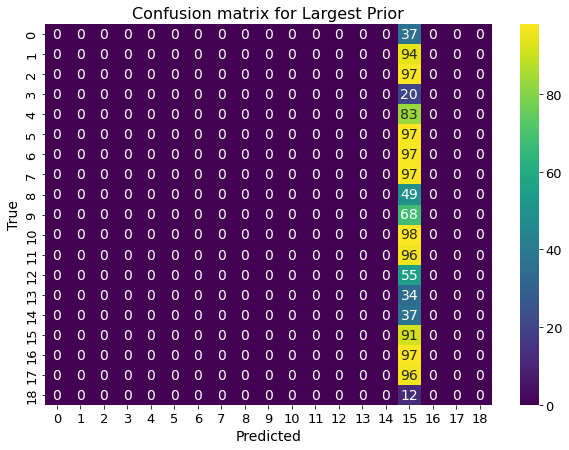

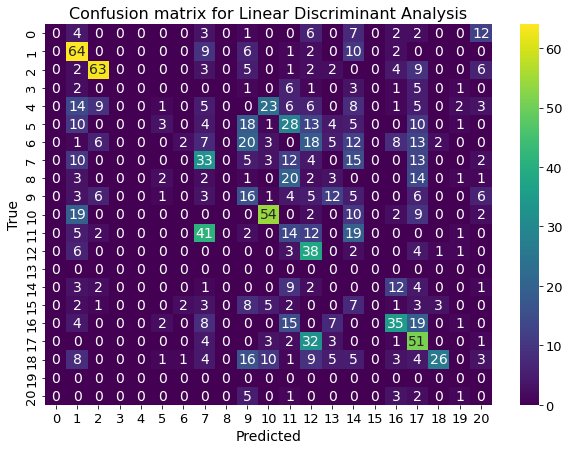

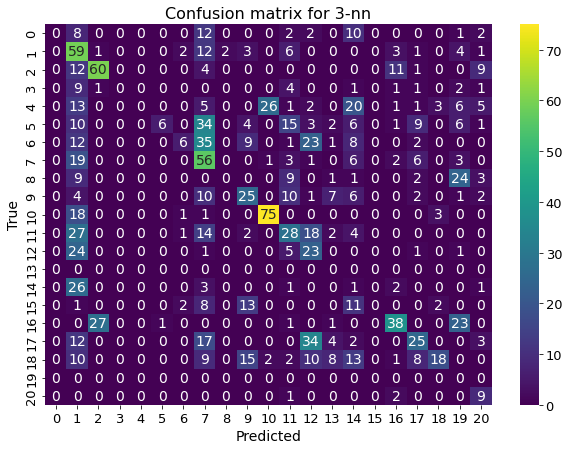

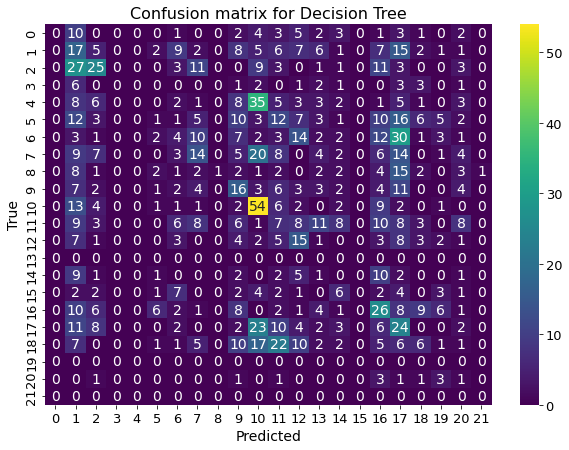

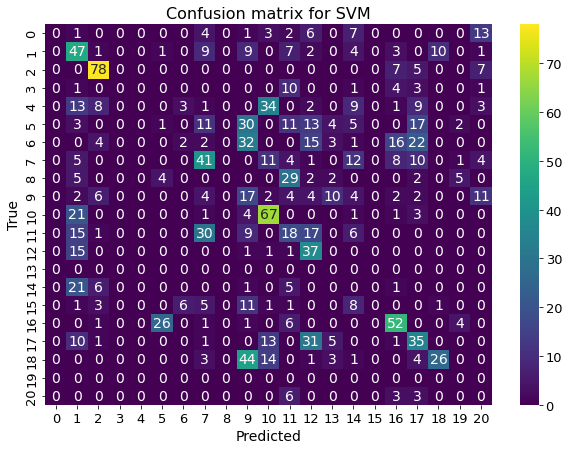

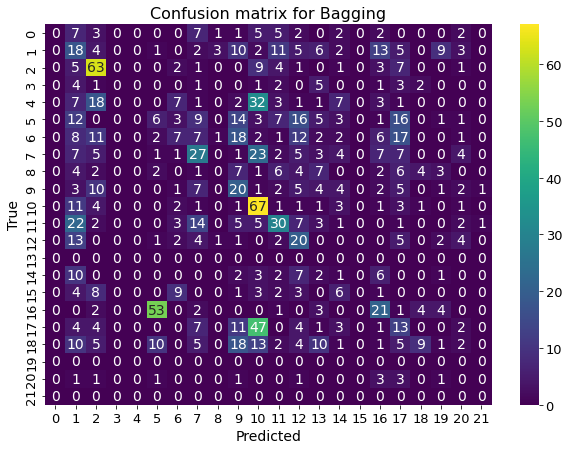

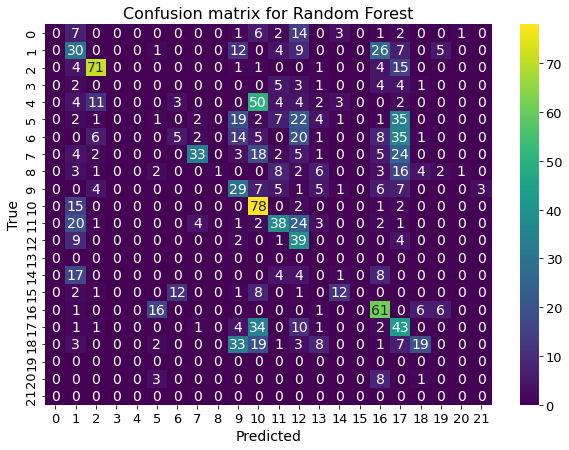


Results for video: Pigs_49651_960_540_500f with feature: DataHOG

Largest Prior:
  Accuracy: 6.715867158671587%
  Precision: 0.4510287169292358%
  Recall: 6.715867158671587%
  F1 Score: 0.8452889508148196%

Linear Discriminant Analysis:
  Accuracy: 29.44649446494465%
  Precision: 32.03037996090536%
  Recall: 29.44649446494465%
  F1 Score: 26.716921534535242%

3-nn:
  Accuracy: 31.660516605166052%
  Precision: 40.16233502723967%
  Recall: 31.660516605166052%
  F1 Score: 29.4776024703868%

Decision Tree:
  Accuracy: 15.571955719557195%
  Precision: 16.782184793157267%
  Recall: 15.571955719557195%
  F1 Score: 13.449555485371379%

SVM:
  Accuracy: 31.070110701107012%
  Precision: 28.192927293473836%
  Recall: 31.070110701107012%
  F1 Score: 27.580131182264672%

Bagging:
  Accuracy: 22.287822878228784%
  Precision: 20.528688385979134%
  Recall: 22.287822878228784%
  F1 Score: 19.479301979191494%

Random Forest:
  Accuracy: 33.13653136531365%
  Precision: 34.830292274685945%
  Recall: 33.1

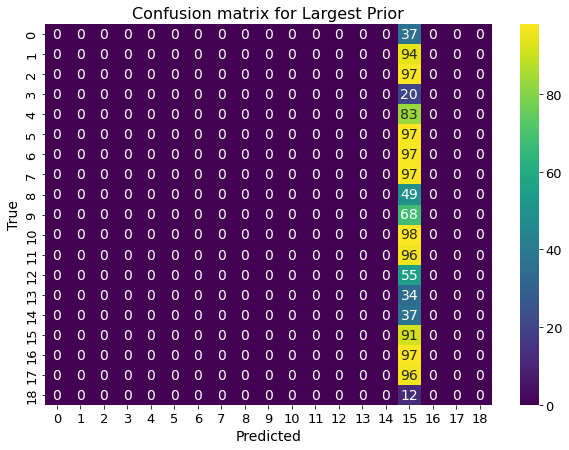

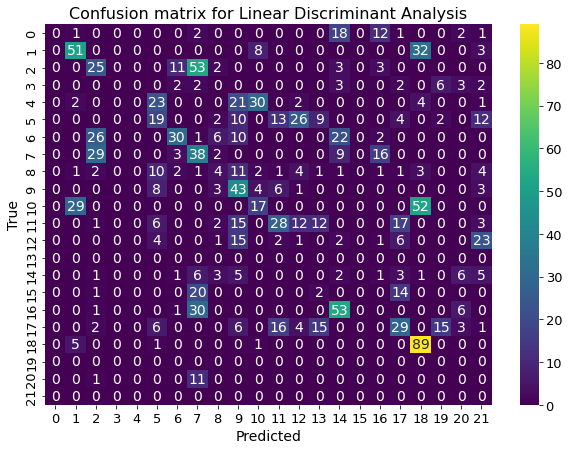

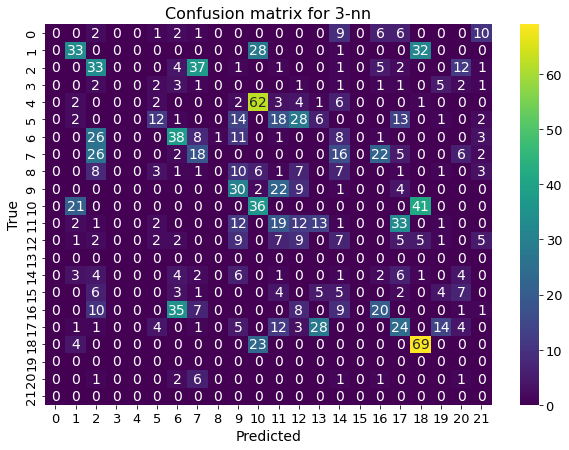

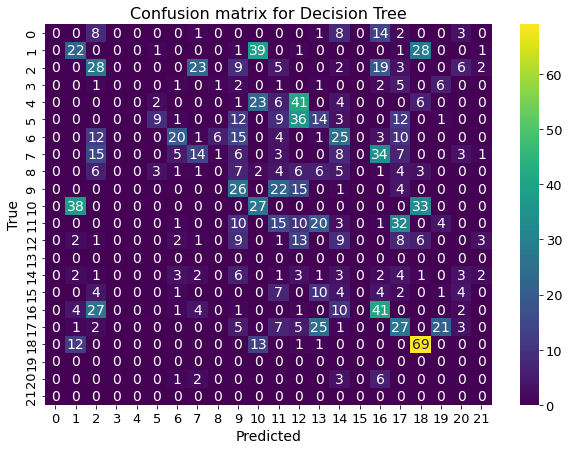

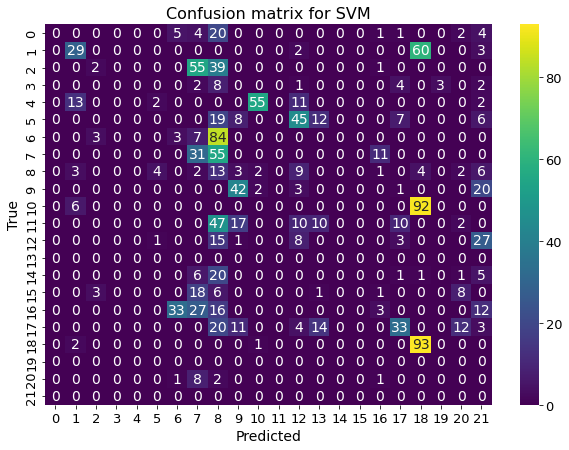

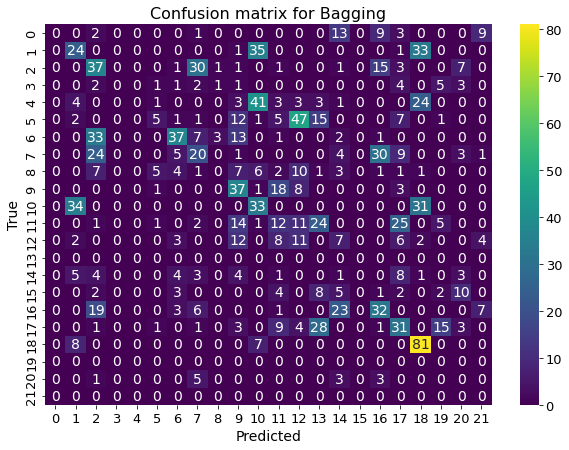

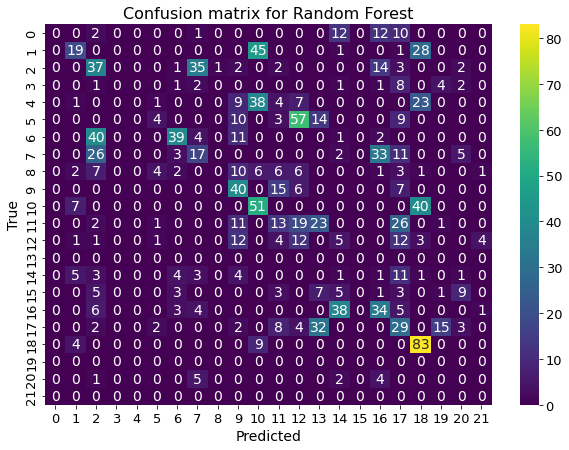


Results for video: Pigs_49651_960_540_500f with feature: DataH10

Largest Prior:
  Accuracy: 6.715867158671587%
  Precision: 0.4510287169292358%
  Recall: 6.715867158671587%
  F1 Score: 0.8452889508148196%

Linear Discriminant Analysis:
  Accuracy: 27.74907749077491%
  Precision: 27.166046645343705%
  Recall: 27.74907749077491%
  F1 Score: 25.937968209066025%

3-nn:
  Accuracy: 25.313653136531368%
  Precision: 25.145507741653738%
  Recall: 25.313653136531368%
  F1 Score: 24.006809569884204%

Decision Tree:
  Accuracy: 23.173431734317344%
  Precision: 25.915545269203953%
  Recall: 23.173431734317344%
  F1 Score: 21.989202397866446%

SVM:
  Accuracy: 18.96678966789668%
  Precision: 18.16584175894729%
  Recall: 18.96678966789668%
  F1 Score: 15.706999010434695%

Bagging:
  Accuracy: 26.642066420664207%
  Precision: 25.787955323979574%
  Recall: 26.642066420664207%
  F1 Score: 24.593579474033938%

Random Forest:
  Accuracy: 27.970479704797047%
  Precision: 27.627534094615534%
  Recall: 27

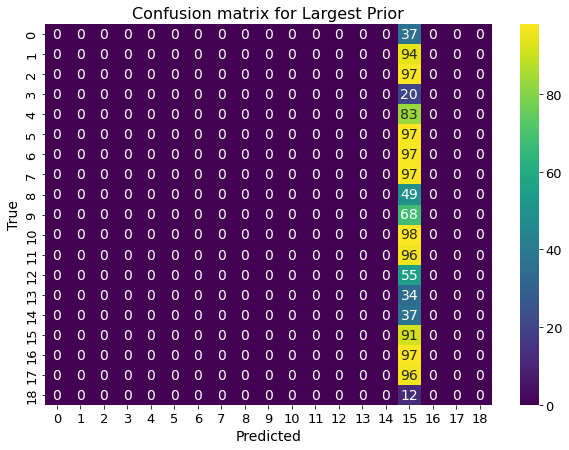

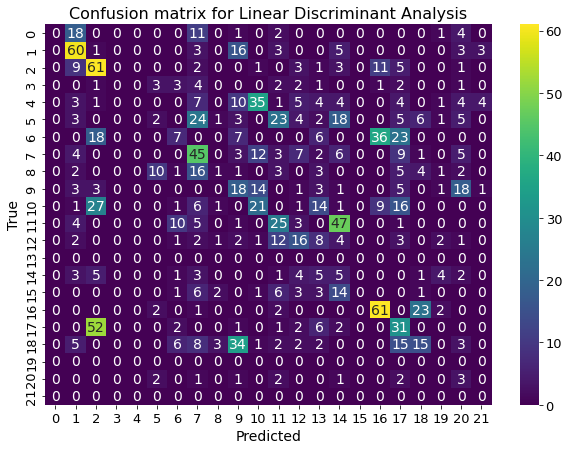

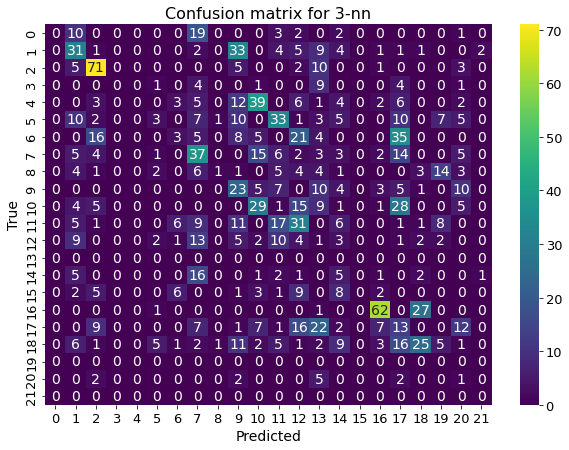

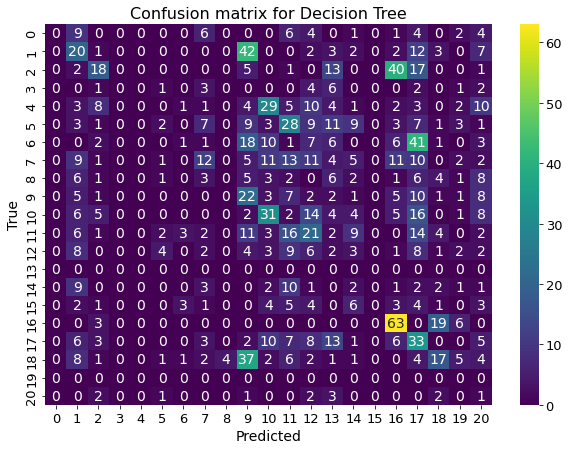

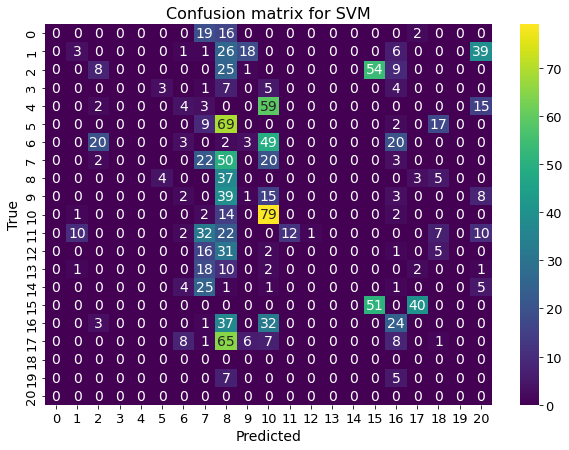

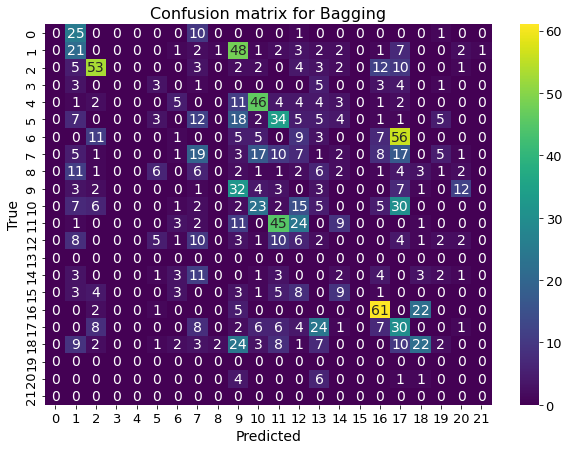

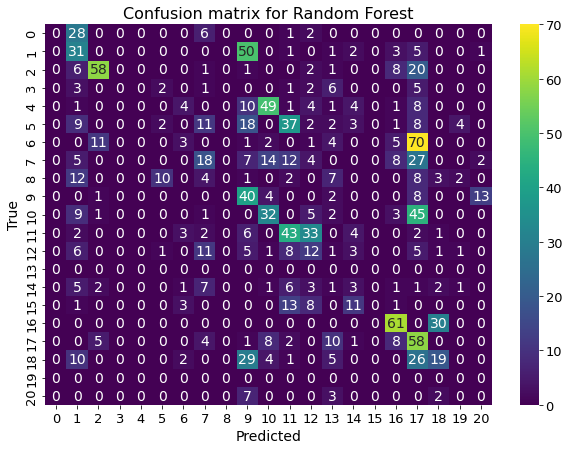


Results for video: Pigs_49651_960_540_500f with feature: DataLBP

Largest Prior:
  Accuracy: 6.715867158671587%
  Precision: 0.4510287169292358%
  Recall: 6.715867158671587%
  F1 Score: 0.8452889508148196%

Linear Discriminant Analysis:
  Accuracy: 27.380073800738007%
  Precision: 24.459284559609422%
  Recall: 27.380073800738007%
  F1 Score: 24.52419467436337%

3-nn:
  Accuracy: 23.985239852398525%
  Precision: 25.10191384454521%
  Recall: 23.985239852398525%
  F1 Score: 22.88884626842796%

Decision Tree:
  Accuracy: 18.00738007380074%
  Precision: 17.832226388600045%
  Recall: 18.00738007380074%
  F1 Score: 16.050811815933745%

SVM:
  Accuracy: 17.712177121771216%
  Precision: 19.841273007036694%
  Recall: 17.712177121771216%
  F1 Score: 13.534700831575075%

Bagging:
  Accuracy: 23.468634686346864%
  Precision: 21.25661830237213%
  Recall: 23.468634686346864%
  F1 Score: 21.17624791853828%

Random Forest:
  Accuracy: 28.044280442804425%
  Precision: 25.4730784685631%
  Recall: 28.044

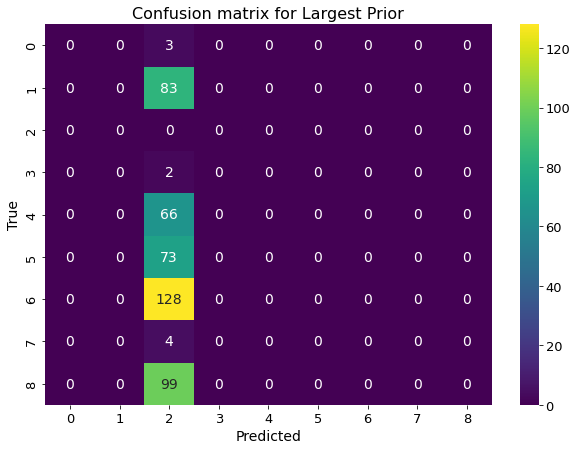

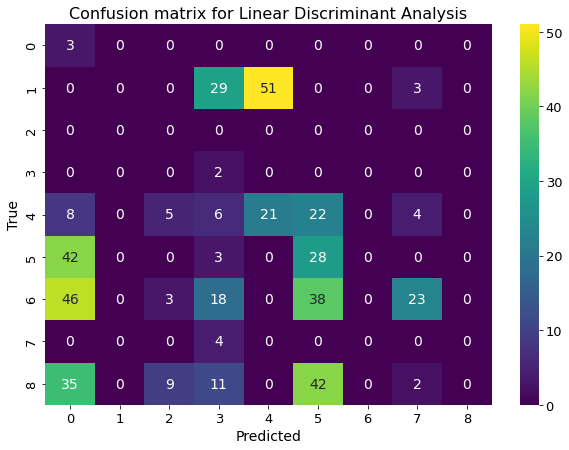

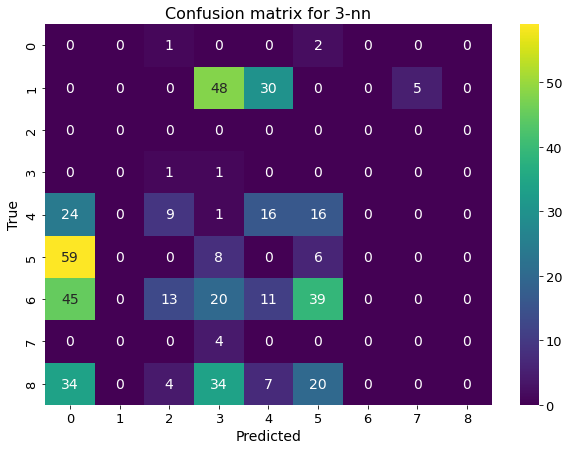

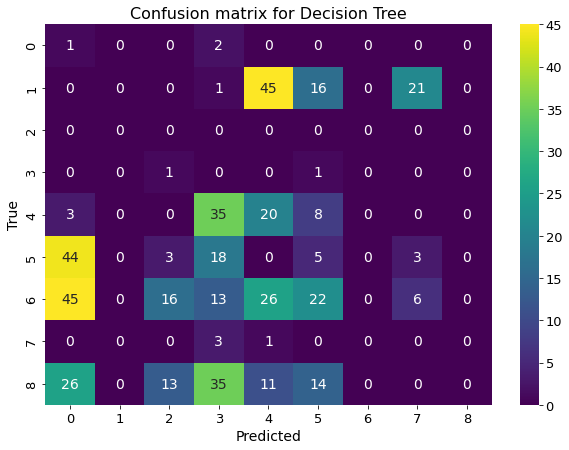

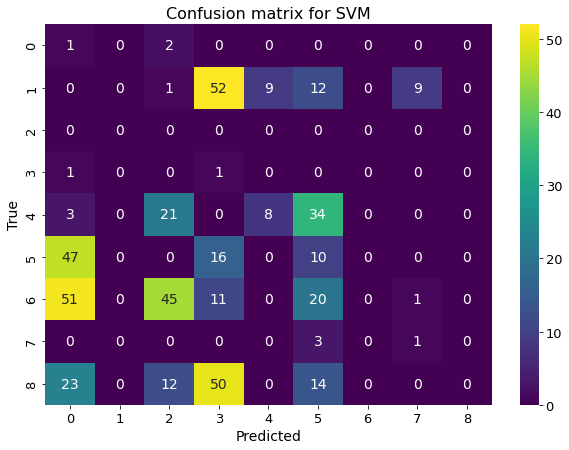

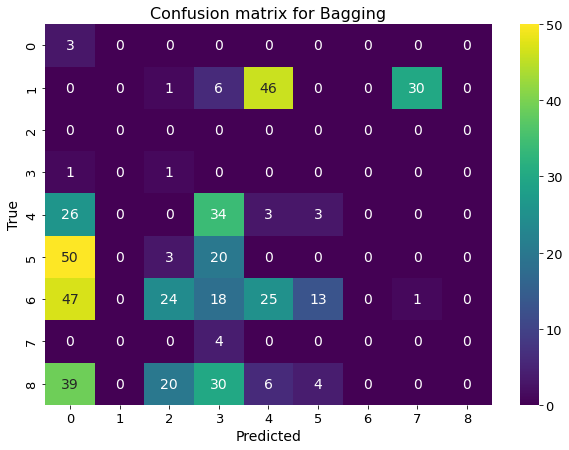

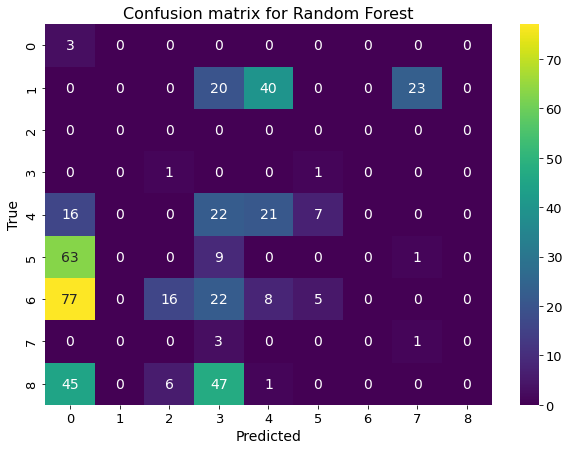


Results for video: Koi_5652_952_540 with feature: DataRGB

Largest Prior:
  Accuracy: 0.0%
  Precision: 0.0%
  Recall: 0.0%
  F1 Score: 0.0%

Linear Discriminant Analysis:
  Accuracy: 11.790393013100436%
  Precision: 7.6626715333470194%
  Recall: 11.790393013100436%
  F1 Score: 8.834703293493979%

3-nn:
  Accuracy: 5.021834061135371%
  Precision: 4.758591662236961%
  Recall: 5.021834061135371%
  F1 Score: 4.780663049481049%

Decision Tree:
  Accuracy: 5.676855895196507%
  Precision: 4.0111456539124815%
  Recall: 5.676855895196507%
  F1 Score: 4.568183551128355%

SVM:
  Accuracy: 4.585152838427948%
  Precision: 8.583213187299926%
  Recall: 4.585152838427948%
  F1 Score: 4.8314891442576355%

Bagging:
  Accuracy: 1.3100436681222707%
  Precision: 0.5522307570894933%
  Recall: 1.3100436681222707%
  F1 Score: 0.6154667342495487%

Random Forest:
  Accuracy: 5.458515283842795%
  Precision: 4.3677112766503985%
  Recall: 5.458515283842795%
  F1 Score: 4.52951343490854%

Processing feature: Data

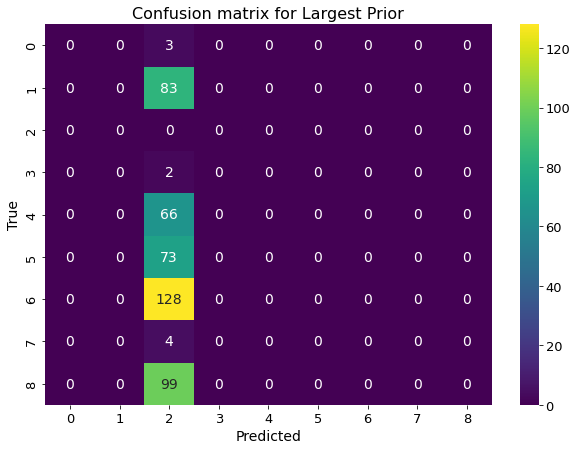

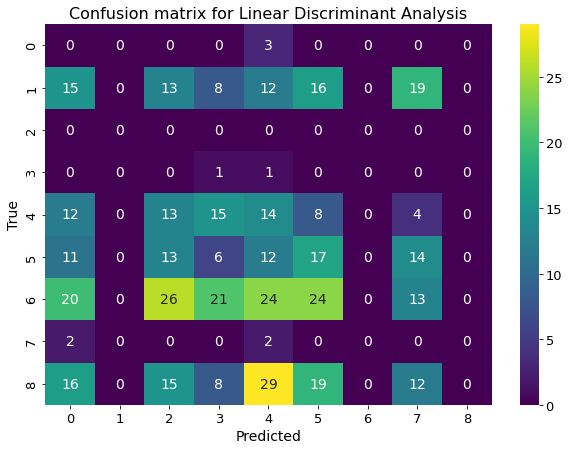

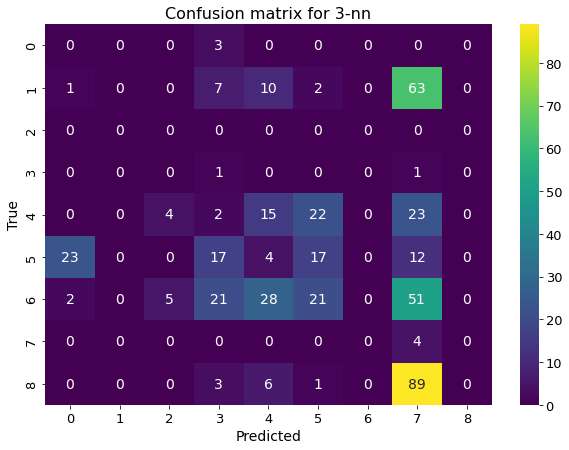

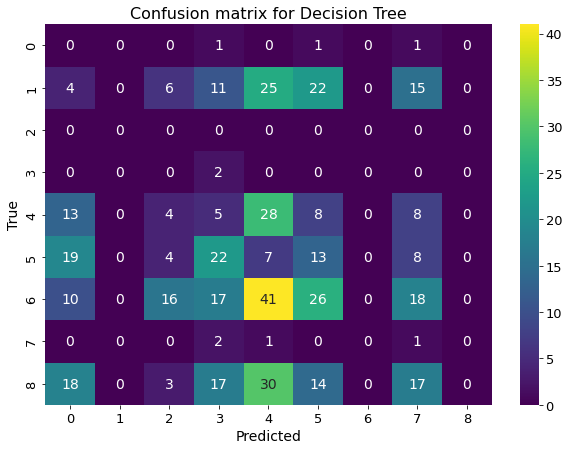

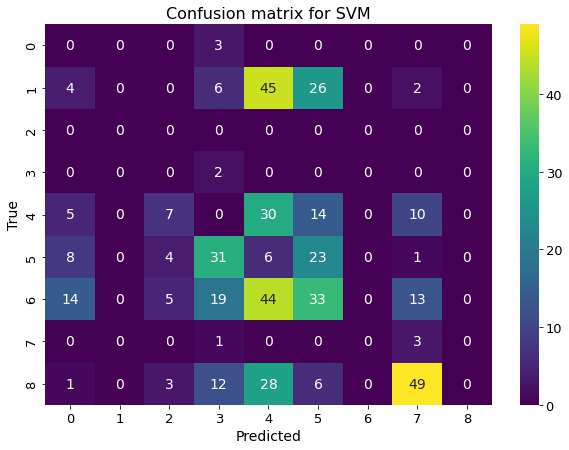

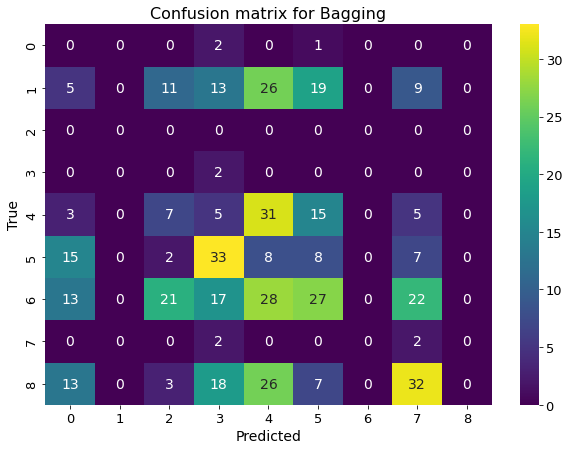

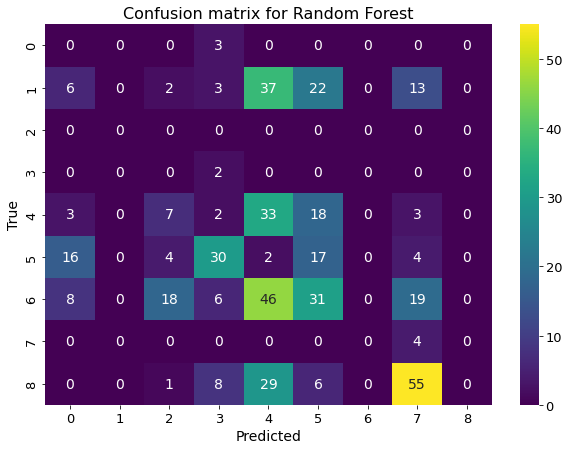


Results for video: Koi_5652_952_540 with feature: DataHOG

Largest Prior:
  Accuracy: 0.0%
  Precision: 0.0%
  Recall: 0.0%
  F1 Score: 0.0%

Linear Discriminant Analysis:
  Accuracy: 6.986899563318777%
  Precision: 5.312987123312349%
  Recall: 6.986899563318777%
  F1 Score: 5.941466000180669%

3-nn:
  Accuracy: 8.078602620087336%
  Precision: 7.7544932469726255%
  Recall: 8.078602620087336%
  F1 Score: 7.3798734577732175%

Decision Tree:
  Accuracy: 9.606986899563319%
  Precision: 5.547683543445167%
  Recall: 9.606986899563319%
  F1 Score: 6.761619121197573%

SVM:
  Accuracy: 12.663755458515283%
  Precision: 6.465035151138412%
  Recall: 12.663755458515283%
  F1 Score: 8.224609016182827%

Bagging:
  Accuracy: 9.388646288209607%
  Precision: 5.442154423603849%
  Recall: 9.388646288209607%
  F1 Score: 6.5913150289873%

Random Forest:
  Accuracy: 12.22707423580786%
  Precision: 6.169387242441754%
  Recall: 12.22707423580786%
  F1 Score: 7.809948102075792%

Processing feature: DataH10


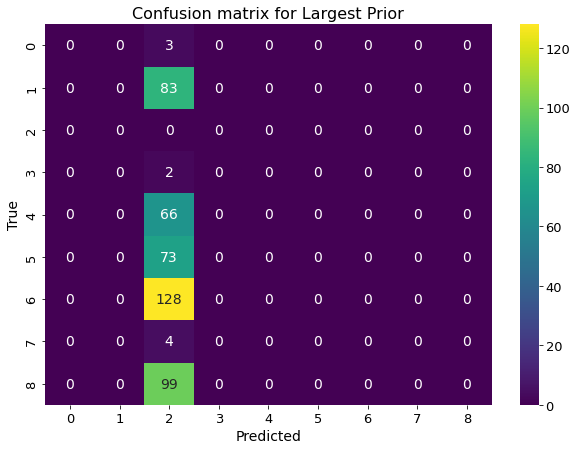

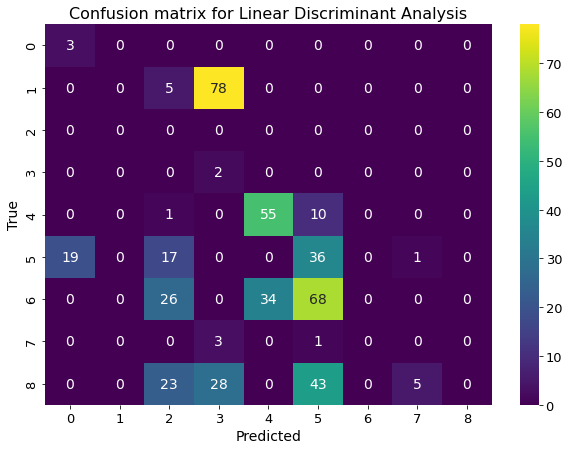

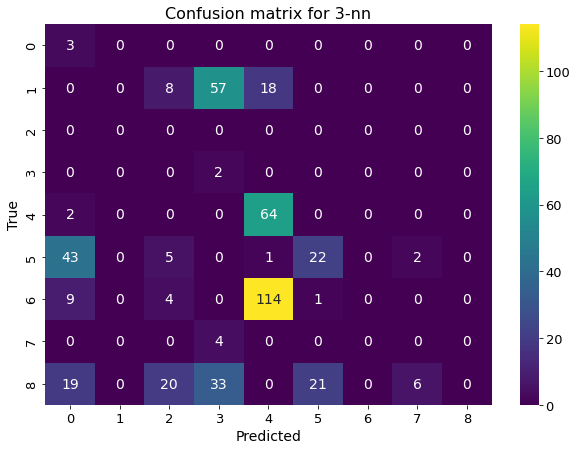

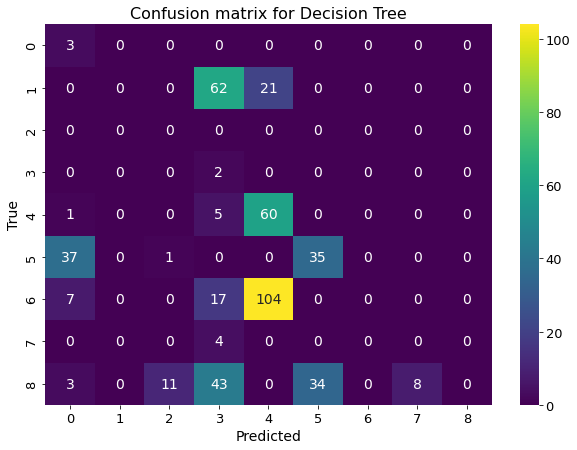

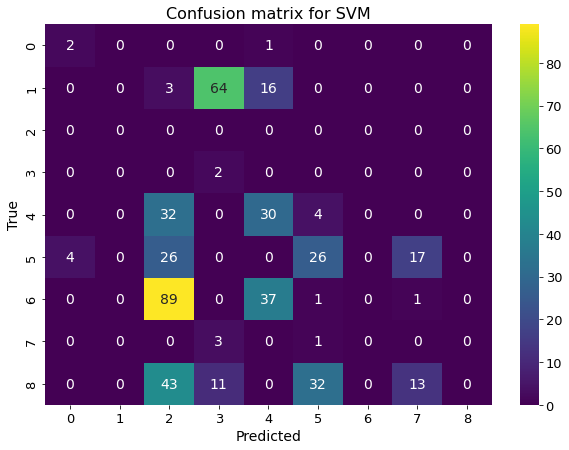

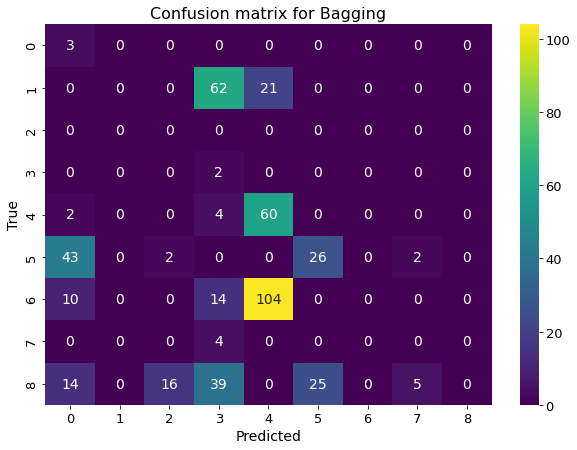

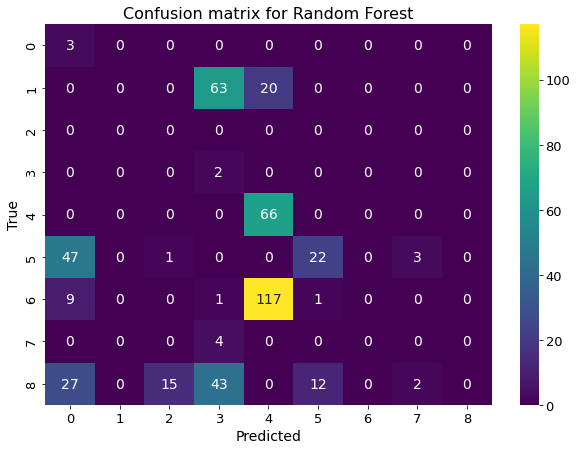


Results for video: Koi_5652_952_540 with feature: DataH10

Largest Prior:
  Accuracy: 0.0%
  Precision: 0.0%
  Recall: 0.0%
  F1 Score: 0.0%

Linear Discriminant Analysis:
  Accuracy: 20.96069868995633%
  Precision: 12.634182356214977%
  Recall: 20.96069868995633%
  F1 Score: 15.36741329494391%

3-nn:
  Accuracy: 19.868995633187772%
  Precision: 12.685963337288314%
  Recall: 19.868995633187772%
  F1 Score: 13.075140875790561%

Decision Tree:
  Accuracy: 21.83406113537118%
  Precision: 12.803697966999348%
  Recall: 21.83406113537118%
  F1 Score: 14.832378372512686%

SVM:
  Accuracy: 13.100436681222707%
  Precision: 11.851021522145976%
  Recall: 13.100436681222707%
  F1 Score: 12.126402512232179%

Bagging:
  Accuracy: 19.868995633187772%
  Precision: 12.833644471597205%
  Recall: 19.868995633187772%
  F1 Score: 13.639668168635039%

Random Forest:
  Accuracy: 20.305676855895197%
  Precision: 14.734474182840875%
  Recall: 20.305676855895197%
  F1 Score: 13.624272980243454%

Processing fea

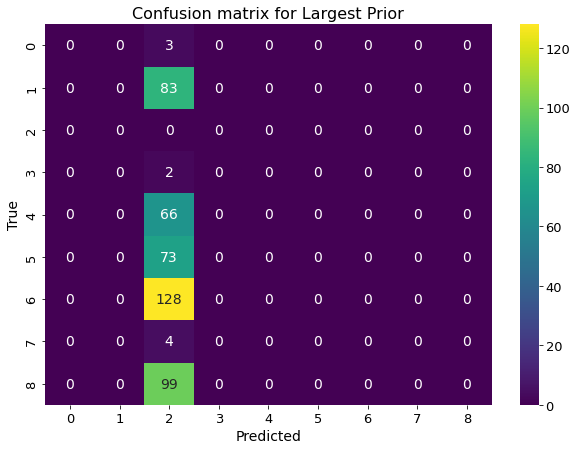

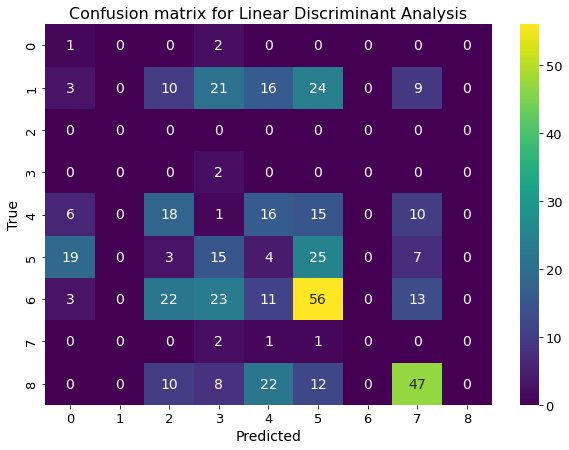

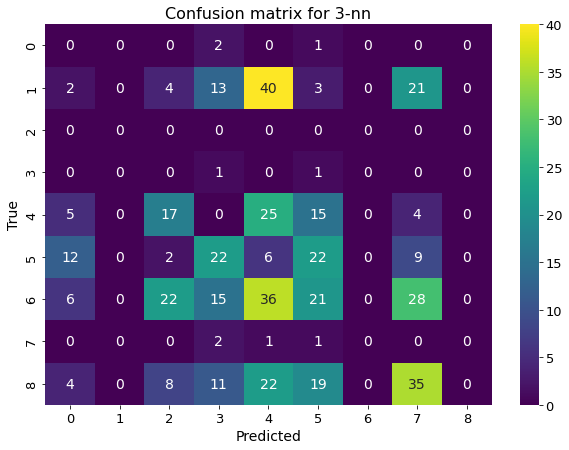

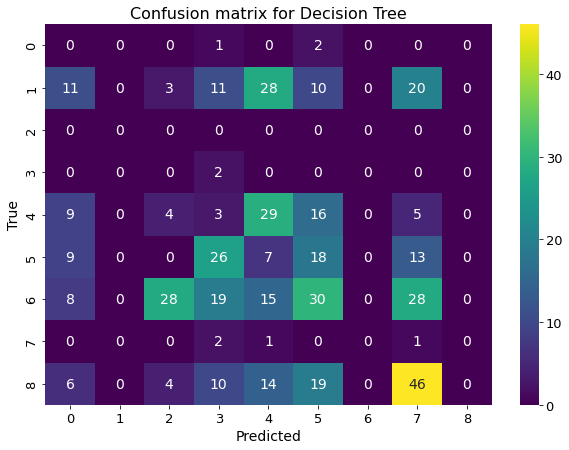

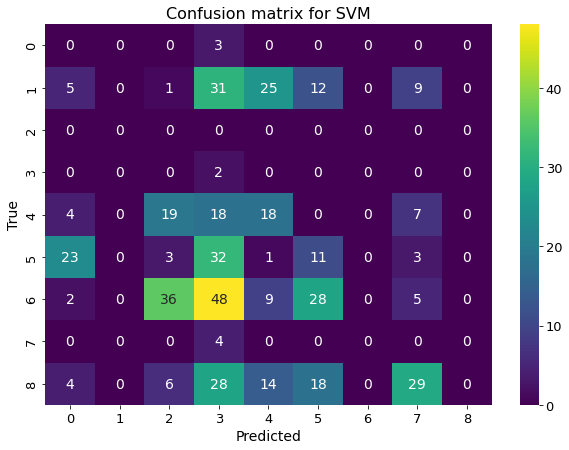

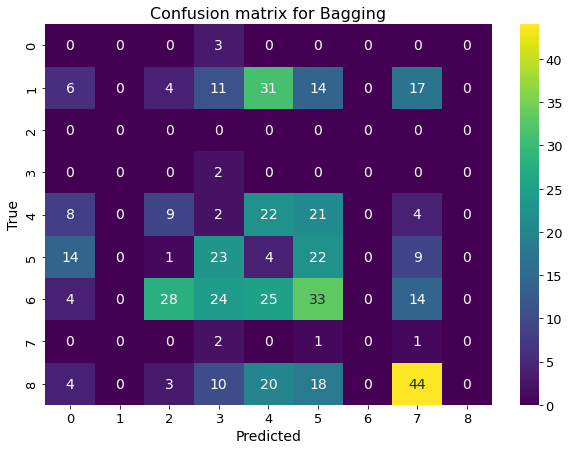

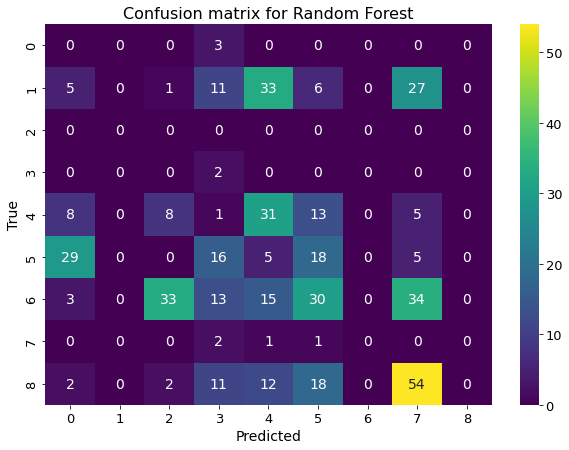


Results for video: Koi_5652_952_540 with feature: DataLBP

Largest Prior:
  Accuracy: 0.0%
  Precision: 0.0%
  Recall: 0.0%
  F1 Score: 0.0%

Linear Discriminant Analysis:
  Accuracy: 9.606986899563319%
  Precision: 6.322122893241601%
  Recall: 9.606986899563319%
  F1 Score: 7.319770763312433%

3-nn:
  Accuracy: 10.480349344978166%
  Precision: 7.0026219023956715%
  Recall: 10.480349344978166%
  F1 Score: 8.184563714636004%

Decision Tree:
  Accuracy: 10.91703056768559%
  Precision: 7.485312960517588%
  Recall: 10.91703056768559%
  F1 Score: 8.677182613346716%

SVM:
  Accuracy: 6.768558951965066%
  Precision: 6.417711971297936%
  Recall: 6.768558951965066%
  F1 Score: 6.380379881372043%

Bagging:
  Accuracy: 10.262008733624455%
  Precision: 6.346316799988706%
  Recall: 10.262008733624455%
  F1 Score: 7.668417742844342%

Random Forest:
  Accuracy: 11.135371179039302%
  Precision: 7.956255432918338%
  Recall: 11.135371179039302%
  F1 Score: 9.118721376922197%

Processing video: Pigeons_

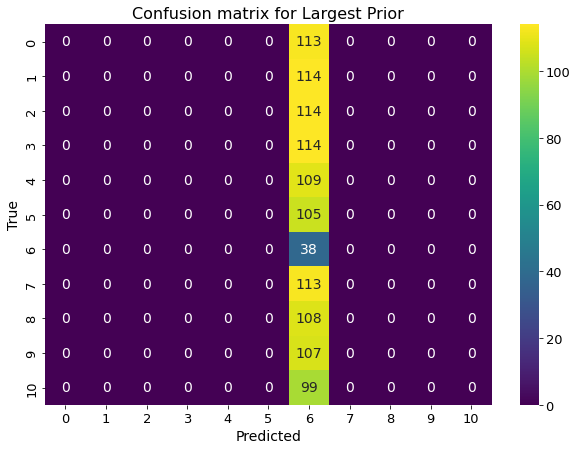

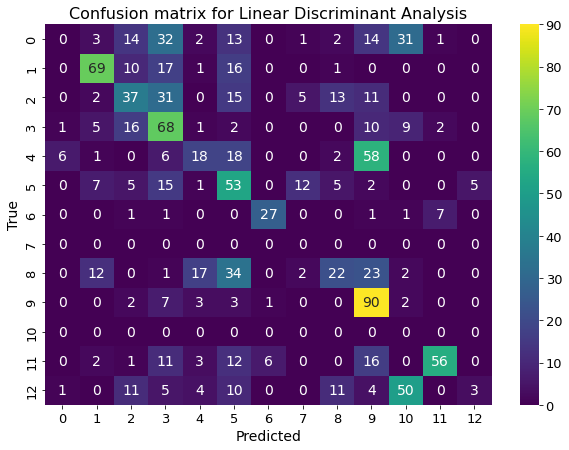

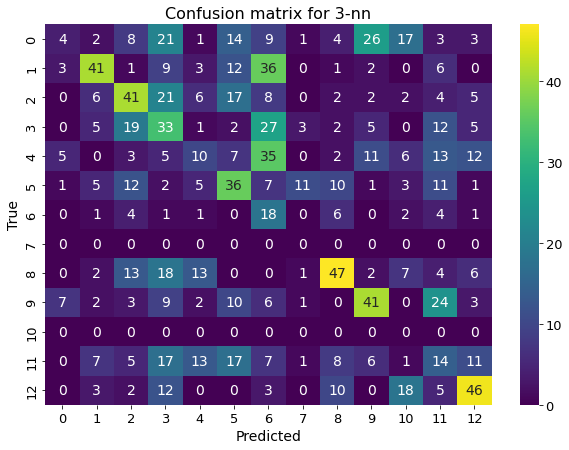

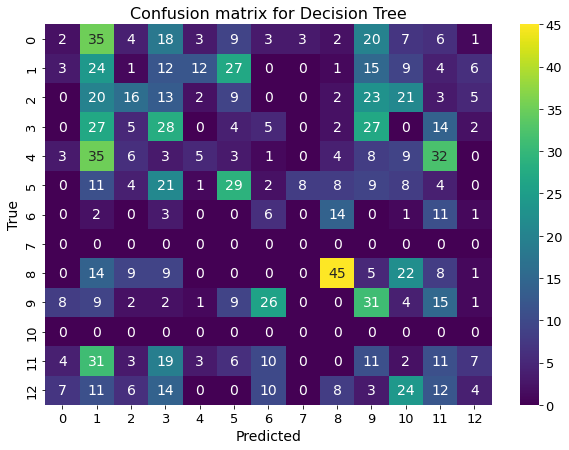

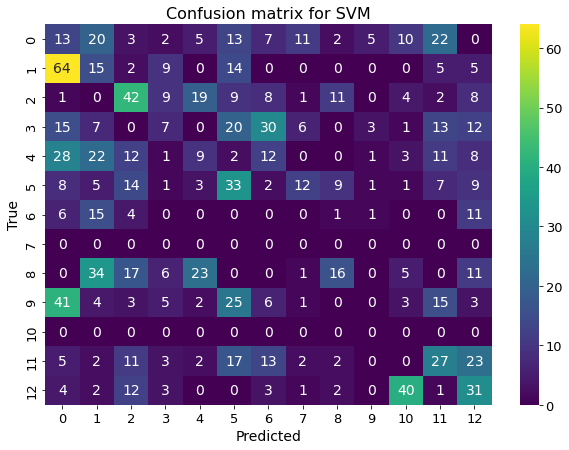

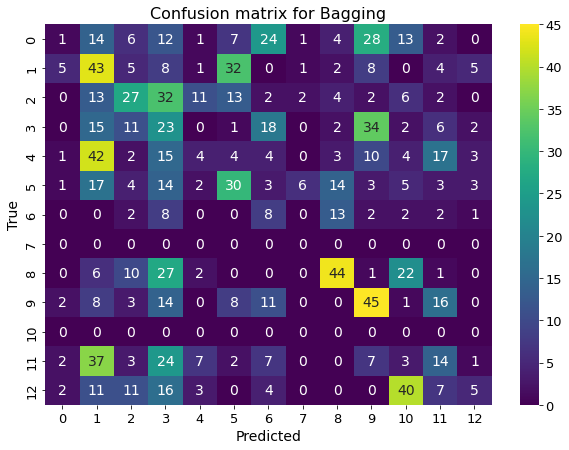

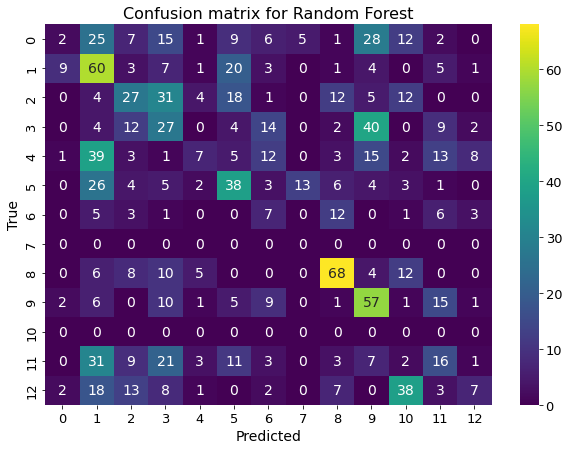


Results for video: Pigeons_8234_1280_720 with feature: DataRGB

Largest Prior:
  Accuracy: 3.3509700176366843%
  Precision: 0.112290000591%
  Recall: 3.3509700176366843%
  F1 Score: 0.21729839704811263%

Linear Discriminant Analysis:
  Accuracy: 39.0652557319224%
  Precision: 42.073318045488094%
  Recall: 39.0652557319224%
  F1 Score: 36.87894538596272%

3-nn:
  Accuracy: 29.188712522045858%
  Precision: 33.347667937780145%
  Recall: 29.188712522045858%
  F1 Score: 29.86153572673987%

Decision Tree:
  Accuracy: 17.724867724867725%
  Precision: 20.859102196896664%
  Recall: 17.724867724867725%
  F1 Score: 17.84400622027735%

SVM:
  Accuracy: 17.019400352733687%
  Precision: 19.03373430601105%
  Recall: 17.019400352733687%
  F1 Score: 17.118653793875126%

Bagging:
  Accuracy: 21.516754850088184%
  Precision: 23.801517305637518%
  Recall: 21.516754850088184%
  F1 Score: 20.91274385934014%

Random Forest:
  Accuracy: 27.86596119929453%
  Precision: 29.230065239137815%
  Recall: 27.8659611

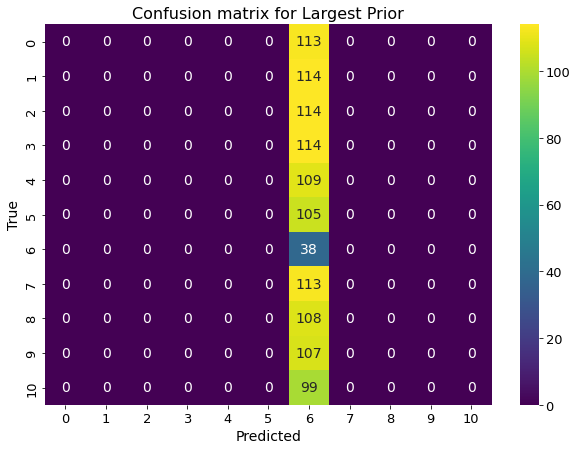

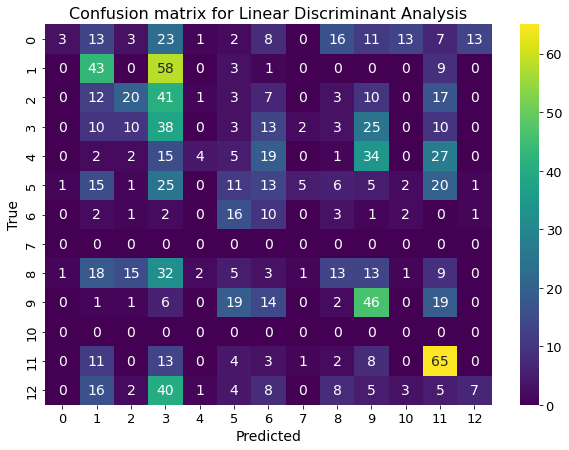

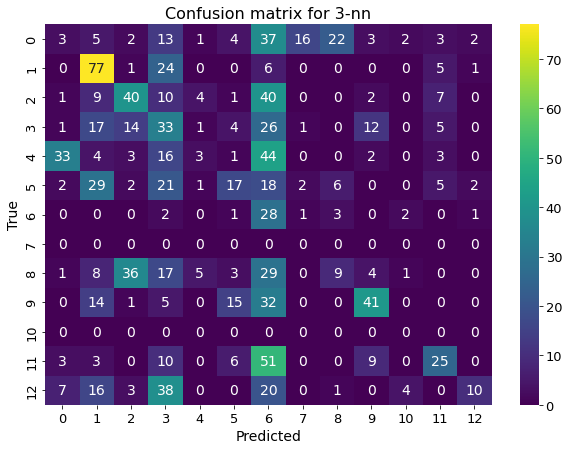

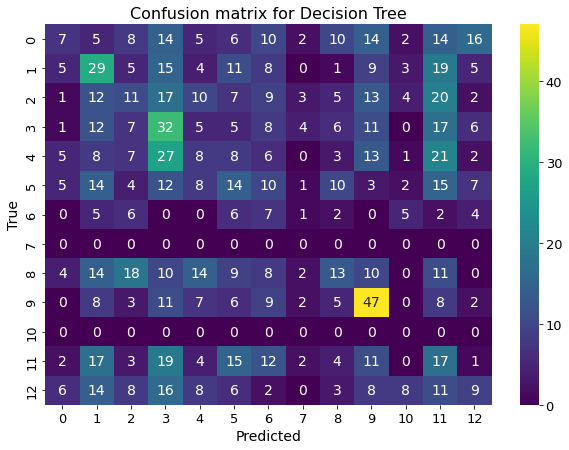

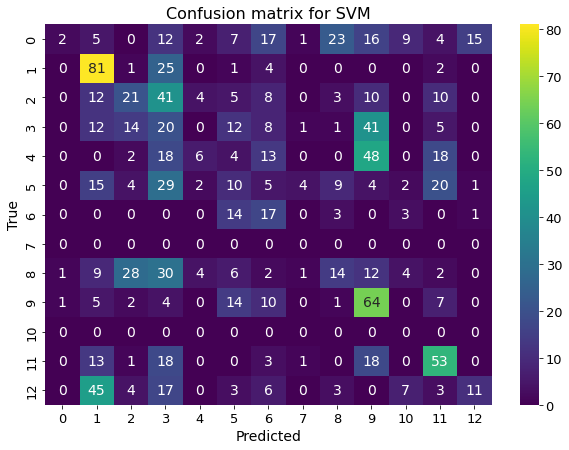

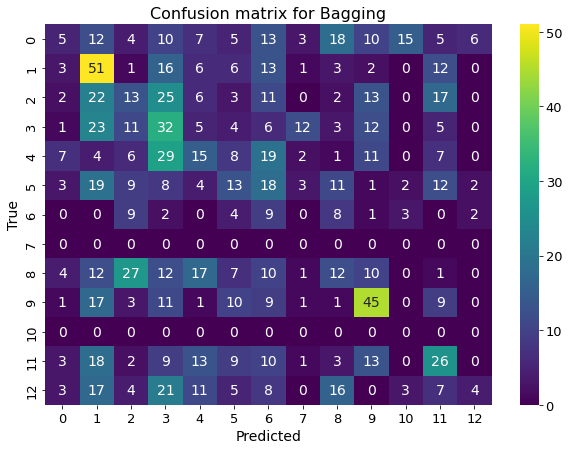

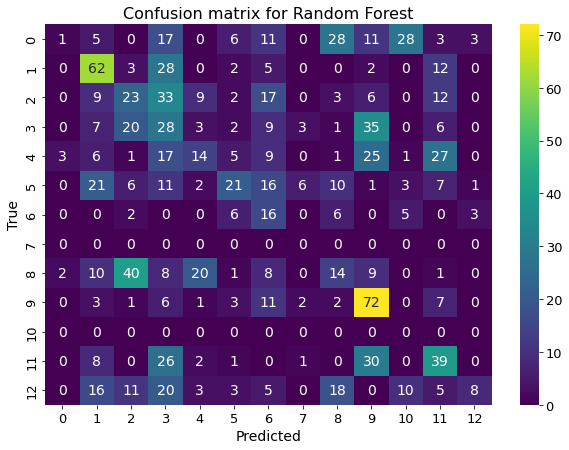


Results for video: Pigeons_8234_1280_720 with feature: DataHOG

Largest Prior:
  Accuracy: 3.3509700176366843%
  Precision: 0.112290000591%
  Recall: 3.3509700176366843%
  F1 Score: 0.21729839704811263%

Linear Discriminant Analysis:
  Accuracy: 22.92768959435626%
  Precision: 31.01514335119545%
  Recall: 22.92768959435626%
  F1 Score: 20.38595888595723%

3-nn:
  Accuracy: 25.220458553791886%
  Precision: 33.21331634109896%
  Recall: 25.220458553791886%
  F1 Score: 24.432954812299997%

Decision Tree:
  Accuracy: 17.10758377425044%
  Precision: 17.80228290745496%
  Recall: 17.10758377425044%
  F1 Score: 16.512098991233557%

SVM:
  Accuracy: 26.366843033509703%
  Precision: 30.603649807064116%
  Recall: 26.366843033509703%
  F1 Score: 23.095834479651277%

Bagging:
  Accuracy: 19.841269841269842%
  Precision: 21.14337609135603%
  Recall: 19.841269841269842%
  F1 Score: 18.740324675897725%

Random Forest:
  Accuracy: 26.278659611992943%
  Precision: 29.264383181146524%
  Recall: 26.278659

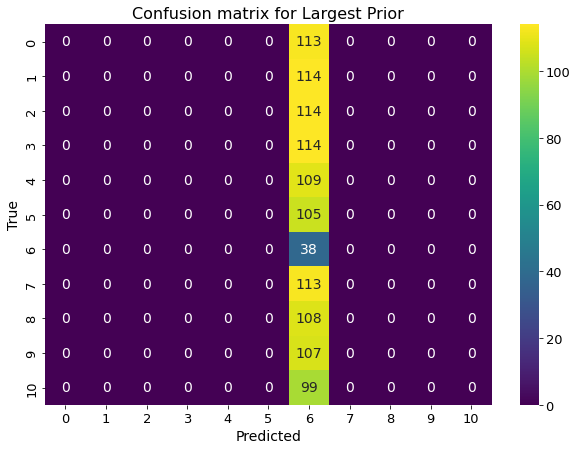

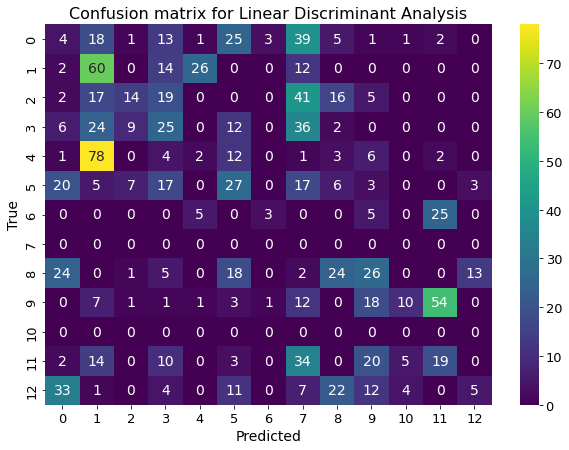

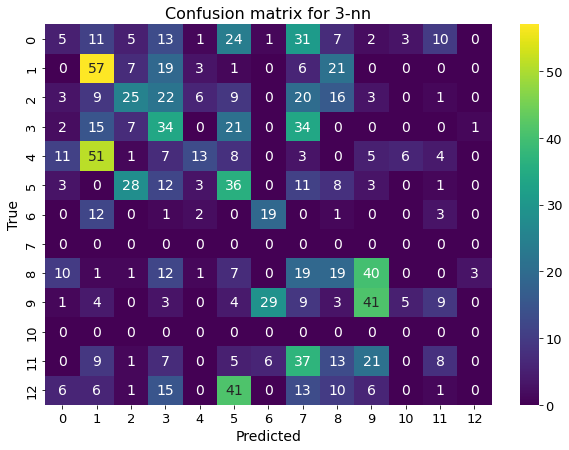

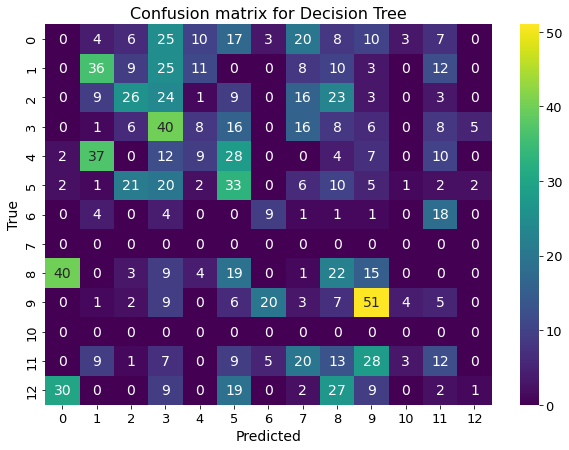

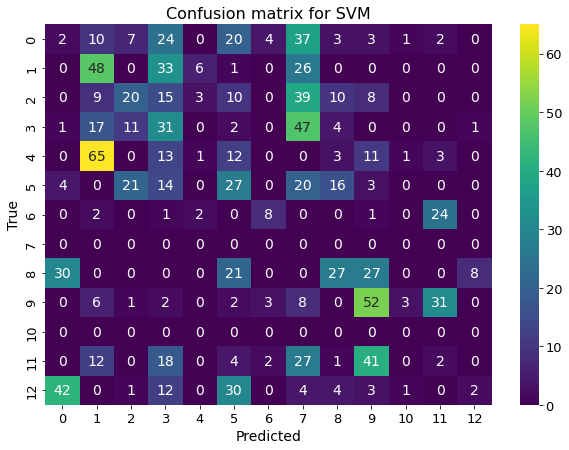

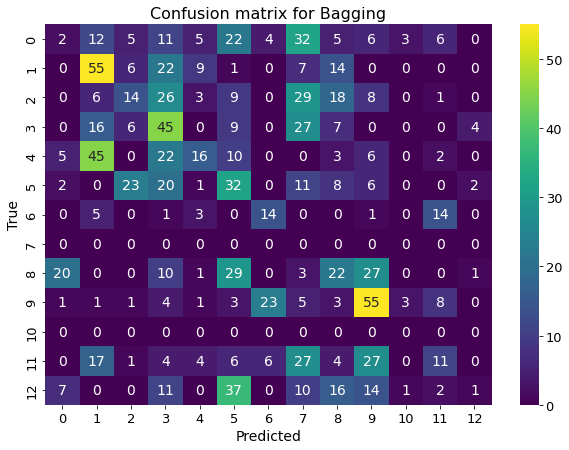

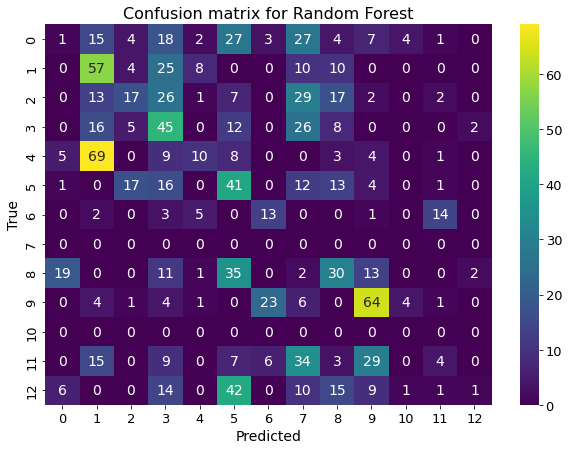


Results for video: Pigeons_8234_1280_720 with feature: DataH10

Largest Prior:
  Accuracy: 3.3509700176366843%
  Precision: 0.112290000591%
  Recall: 3.3509700176366843%
  F1 Score: 0.21729839704811263%

Linear Discriminant Analysis:
  Accuracy: 17.724867724867725%
  Precision: 22.55124761936352%
  Recall: 17.724867724867725%
  F1 Score: 17.74971484827354%

3-nn:
  Accuracy: 22.663139329805997%
  Precision: 24.956031878781285%
  Recall: 22.663139329805997%
  F1 Score: 21.88516244425501%

Decision Tree:
  Accuracy: 21.075837742504408%
  Precision: 21.65429241011165%
  Recall: 21.075837742504408%
  F1 Score: 20.211350479609123%

SVM:
  Accuracy: 19.400352733686066%
  Precision: 21.803391012727843%
  Recall: 19.400352733686066%
  F1 Score: 18.803830017423657%

Bagging:
  Accuracy: 23.544973544973544%
  Precision: 24.72841731650648%
  Recall: 23.544973544973544%
  F1 Score: 22.159402925150808%

Random Forest:
  Accuracy: 24.95590828924162%
  Precision: 26.64782778797077%
  Recall: 24.9559

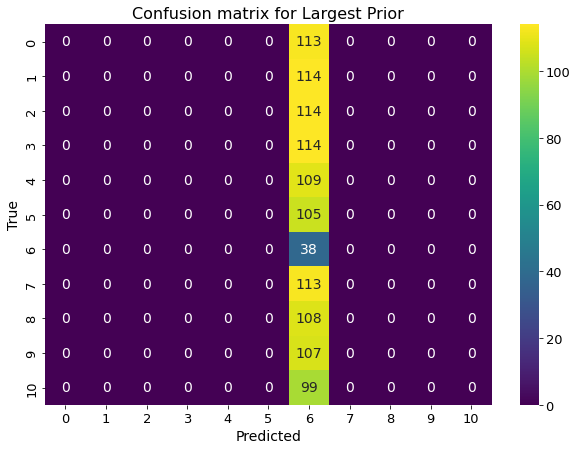

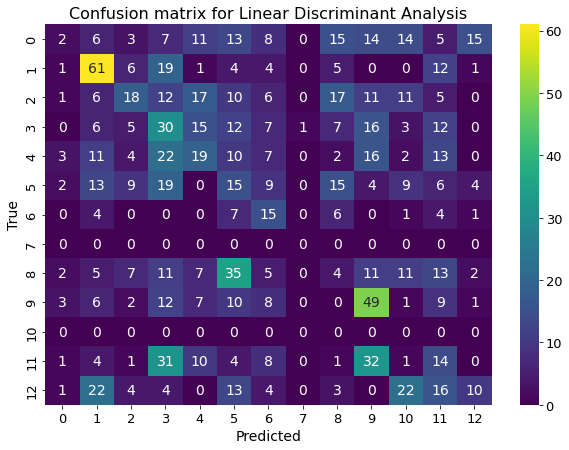

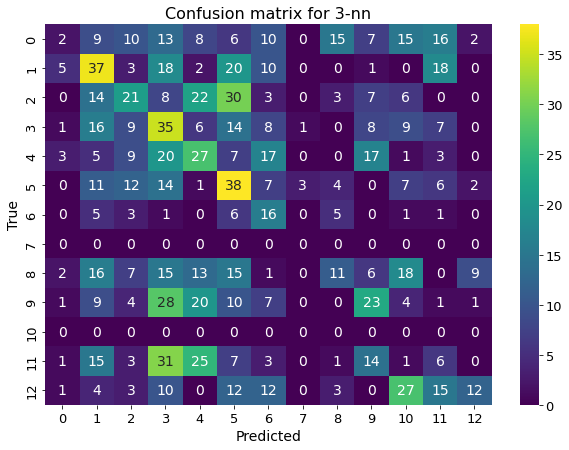

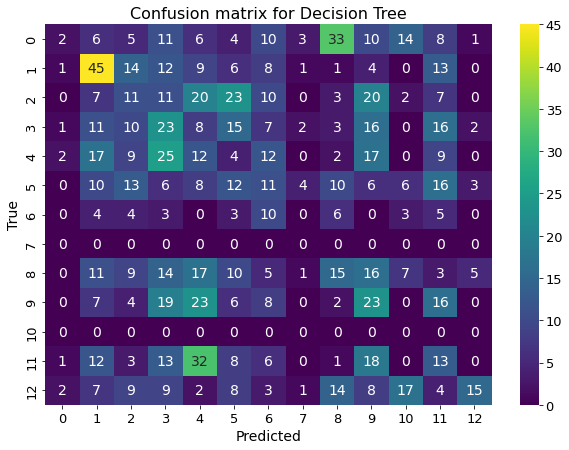

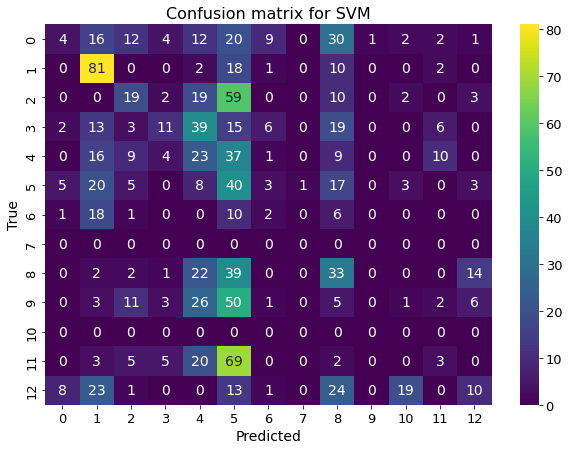

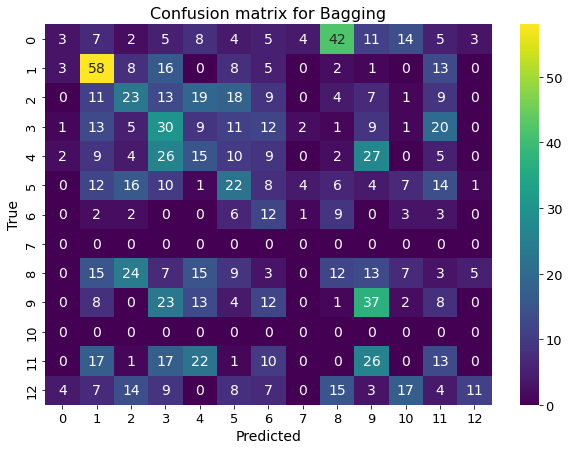

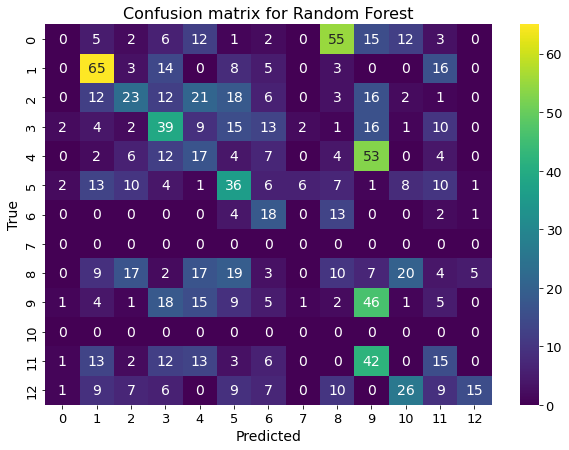


Results for video: Pigeons_8234_1280_720 with feature: DataLBP

Largest Prior:
  Accuracy: 3.3509700176366843%
  Precision: 0.112290000591%
  Recall: 3.3509700176366843%
  F1 Score: 0.21729839704811263%

Linear Discriminant Analysis:
  Accuracy: 20.8994708994709%
  Precision: 21.502184998835162%
  Recall: 20.8994708994709%
  F1 Score: 19.712578075821195%

3-nn:
  Accuracy: 20.105820105820104%
  Precision: 23.069402132395286%
  Recall: 20.105820105820104%
  F1 Score: 19.310540210911086%

Decision Tree:
  Accuracy: 15.961199294532626%
  Precision: 20.051728675001268%
  Recall: 15.961199294532626%
  F1 Score: 15.818719799241393%

SVM:
  Accuracy: 19.929453262786595%
  Precision: 20.721550336732086%
  Recall: 19.929453262786595%
  F1 Score: 16.937884616451377%

Bagging:
  Accuracy: 20.811287477954142%
  Precision: 23.994641500649568%
  Recall: 20.811287477954142%
  F1 Score: 19.9508636631956%

Random Forest:
  Accuracy: 25.044091710758376%
  Precision: 26.985388852588244%
  Recall: 25.044

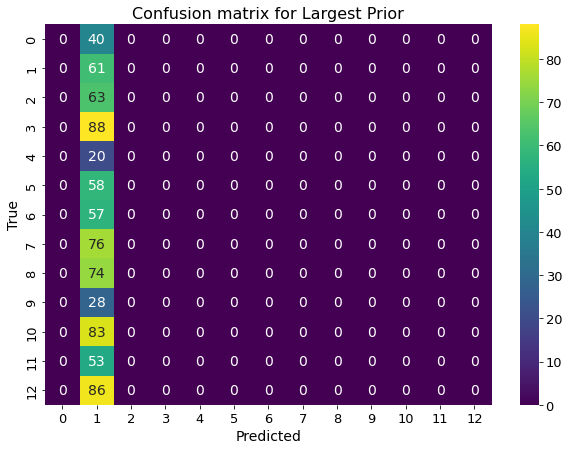

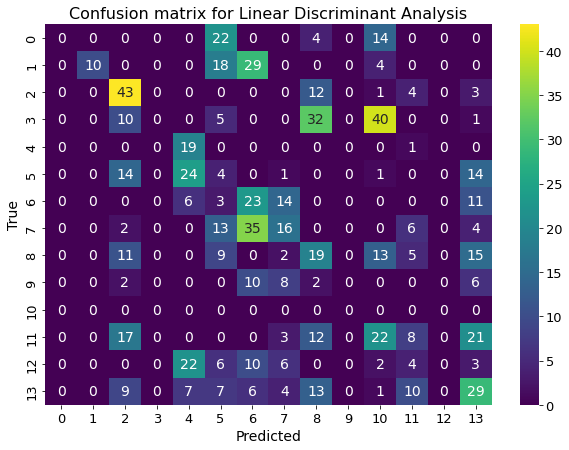

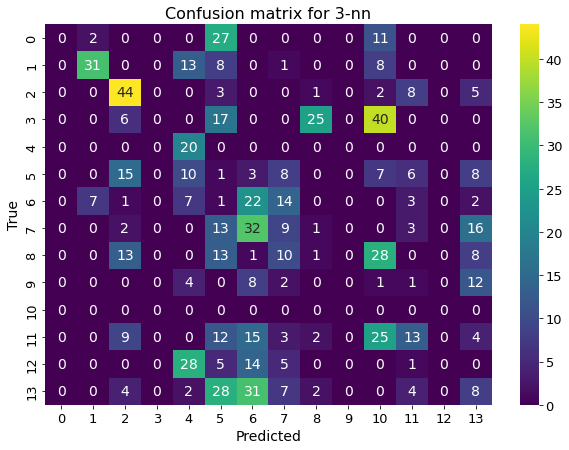

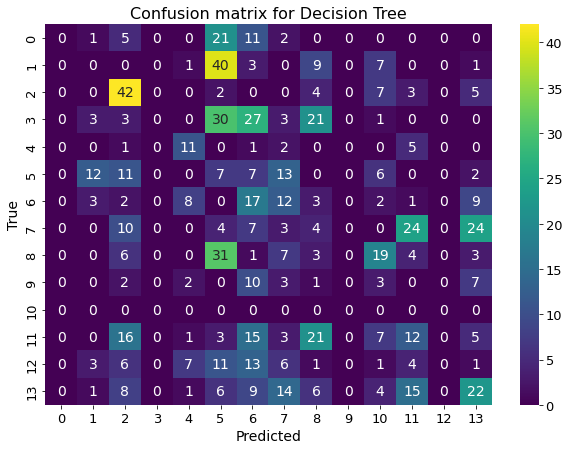

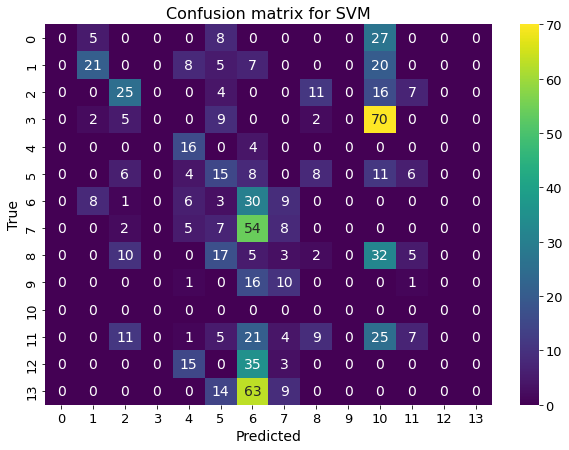

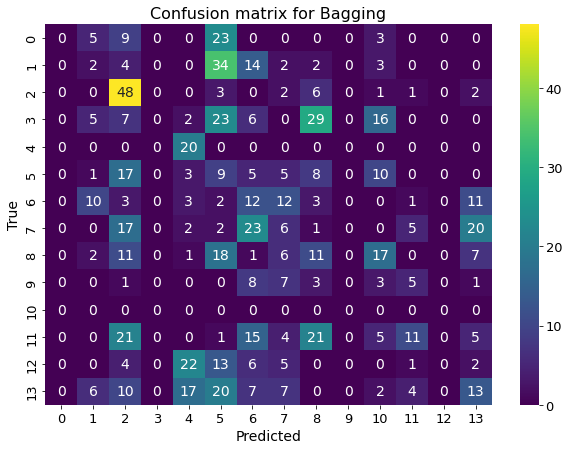

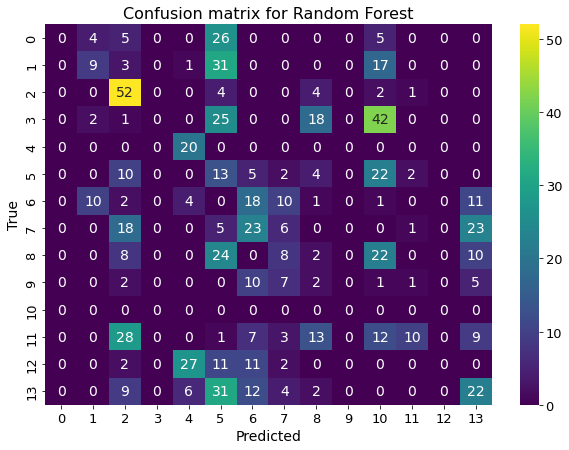


Results for video: Pigeons_4927_960_540_600f with feature: DataRGB

Largest Prior:
  Accuracy: 7.750952986022871%
  Precision: 0.6007727219153688%
  Recall: 7.750952986022871%
  F1 Score: 1.1151135192155546%

Linear Discriminant Analysis:
  Accuracy: 21.72808132147395%
  Precision: 23.314056611919696%
  Recall: 21.72808132147395%
  F1 Score: 18.743518972464567%

3-nn:
  Accuracy: 18.932655654383733%
  Precision: 18.351308048627445%
  Recall: 18.932655654383733%
  F1 Score: 16.929035803279188%

Decision Tree:
  Accuracy: 14.866581956797967%
  Precision: 10.970756858206675%
  Recall: 14.866581956797967%
  F1 Score: 12.182942712325042%

SVM:
  Accuracy: 15.756035578144854%
  Precision: 15.854282240807846%
  Recall: 15.756035578144854%
  F1 Score: 13.629402321069747%

Bagging:
  Accuracy: 16.772554002541295%
  Precision: 13.836267457315568%
  Recall: 16.772554002541295%
  F1 Score: 13.023709858942134%

Random Forest:
  Accuracy: 19.3138500635324%
  Precision: 20.540534752509235%
  Recall:

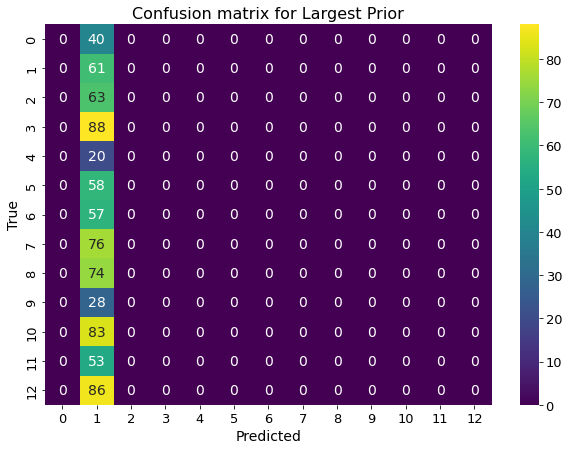

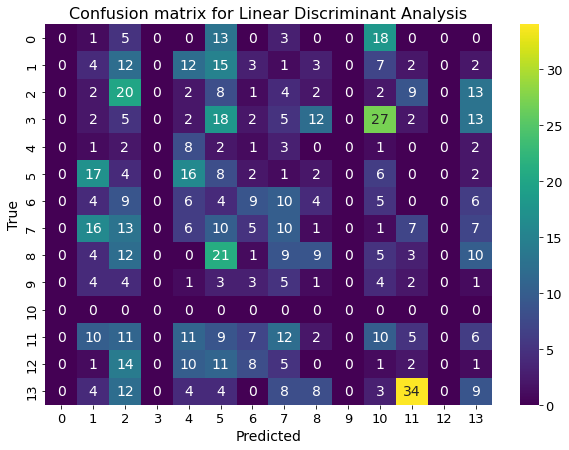

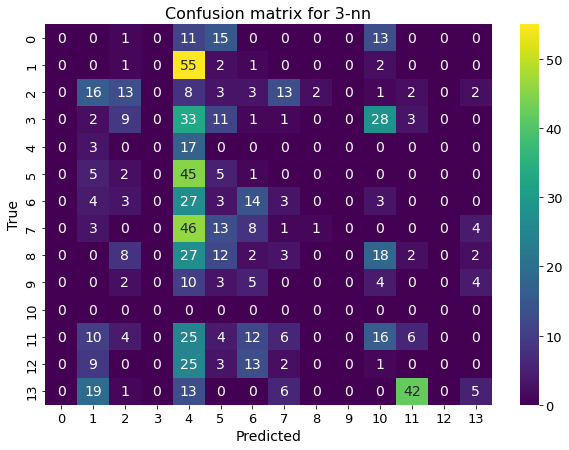

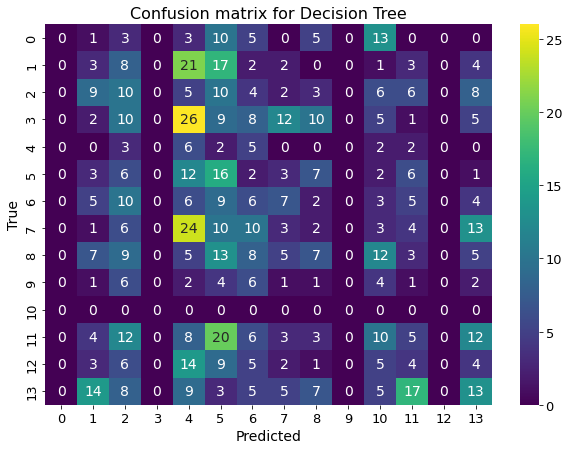

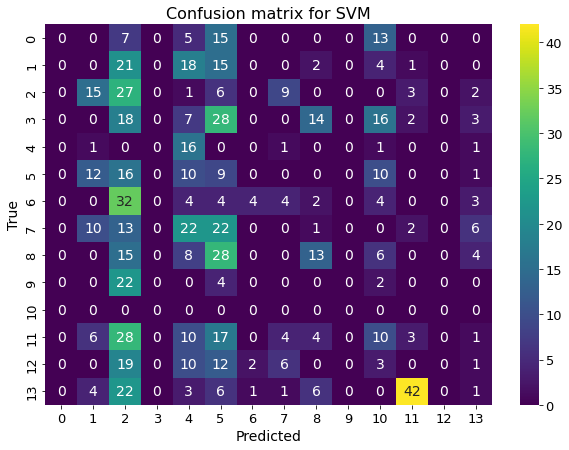

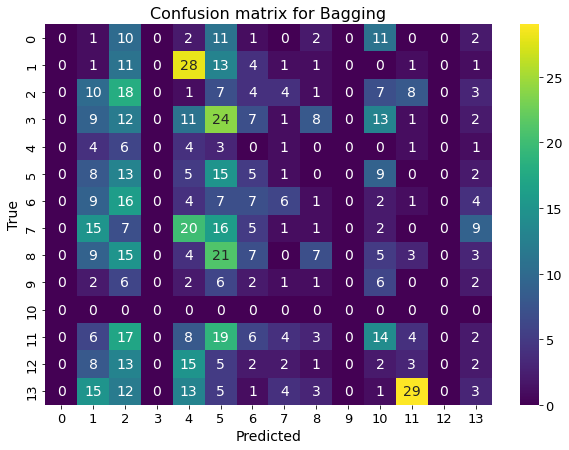

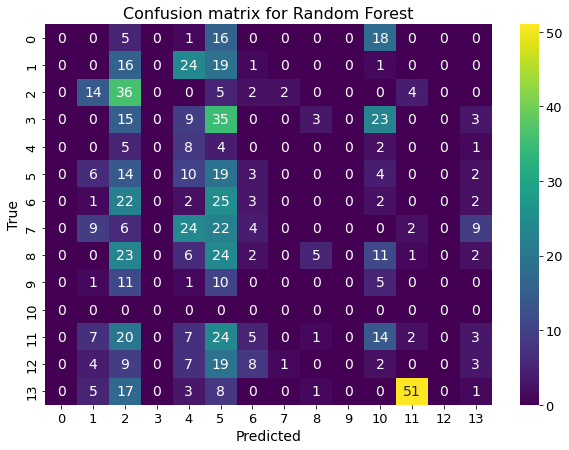


Results for video: Pigeons_4927_960_540_600f with feature: DataHOG

Largest Prior:
  Accuracy: 7.750952986022871%
  Precision: 0.6007727219153688%
  Recall: 7.750952986022871%
  F1 Score: 1.1151135192155546%

Linear Discriminant Analysis:
  Accuracy: 10.419313850063533%
  Precision: 9.383985590481393%
  Recall: 10.419313850063533%
  F1 Score: 9.225168034273468%

3-nn:
  Accuracy: 7.750952986022871%
  Precision: 9.319796569551686%
  Recall: 7.750952986022871%
  F1 Score: 6.627459278960145%

Decision Tree:
  Accuracy: 8.767471410419315%
  Precision: 7.809981749752604%
  Recall: 8.767471410419315%
  F1 Score: 7.6337946816738045%

SVM:
  Accuracy: 9.275730622617536%
  Precision: 9.777958065518796%
  Recall: 9.275730622617536%
  F1 Score: 6.304384970112683%

Bagging:
  Accuracy: 7.6238881829733165%
  Precision: 7.190684565628129%
  Recall: 7.6238881829733165%
  F1 Score: 6.18856203958221%

Random Forest:
  Accuracy: 9.40279542566709%
  Precision: 8.505516970131058%
  Recall: 9.402795425667

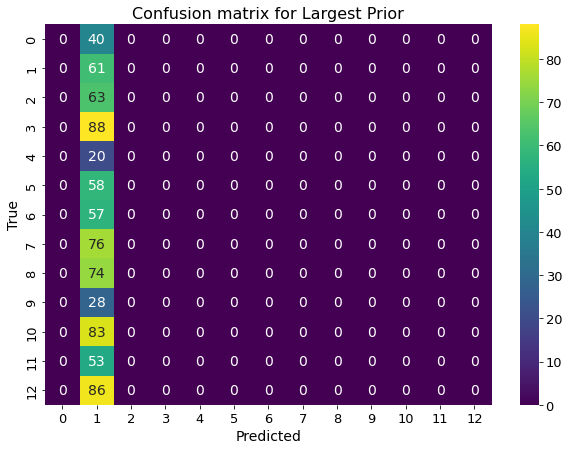

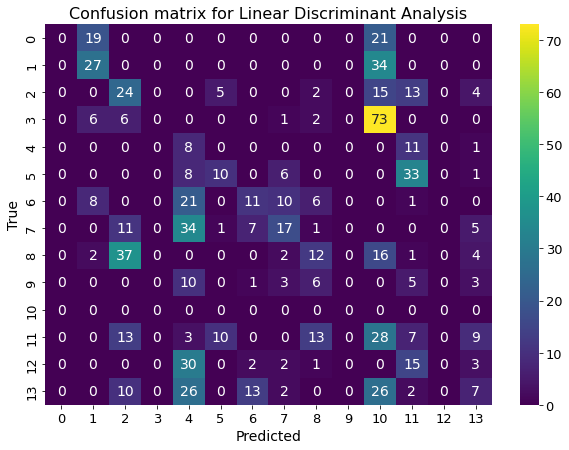

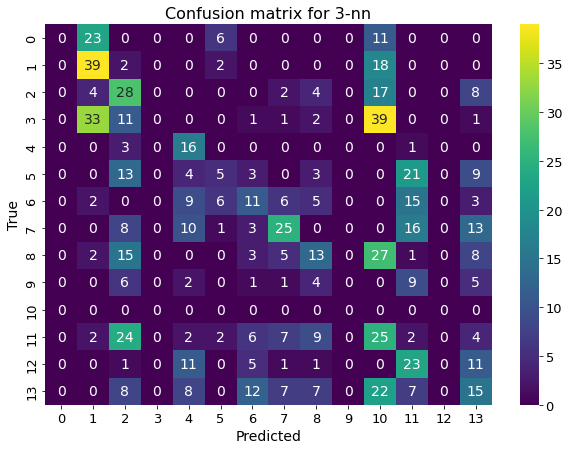

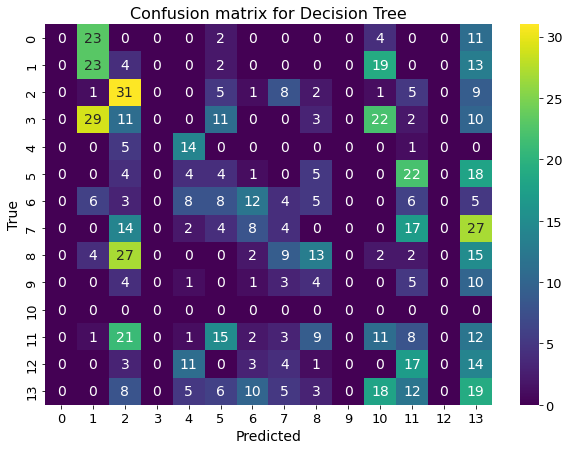

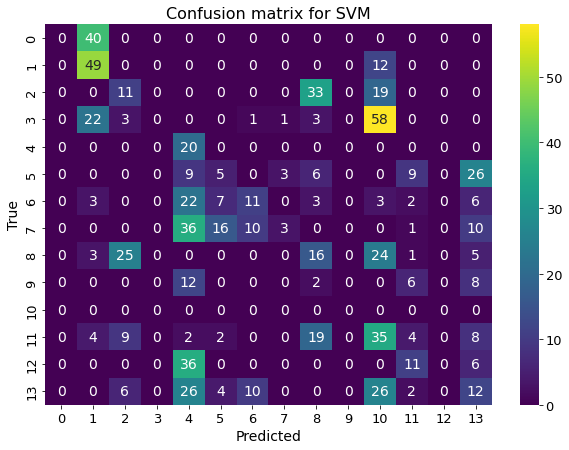

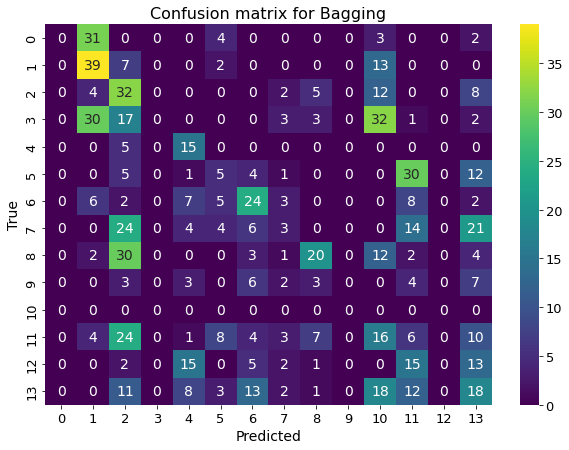

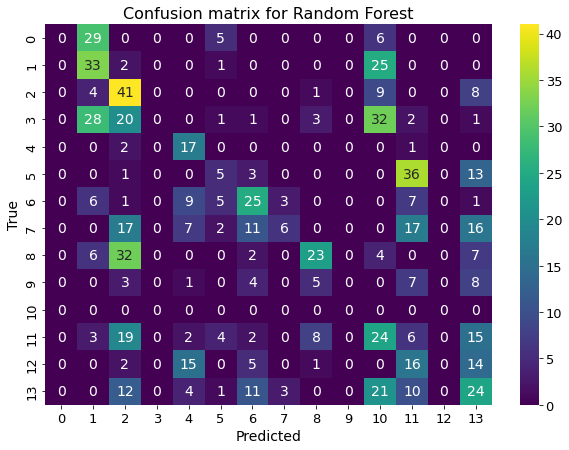


Results for video: Pigeons_4927_960_540_600f with feature: DataH10

Largest Prior:
  Accuracy: 7.750952986022871%
  Precision: 0.6007727219153688%
  Recall: 7.750952986022871%
  F1 Score: 1.1151135192155546%

Linear Discriminant Analysis:
  Accuracy: 15.628970775095299%
  Precision: 19.94876194358584%
  Recall: 15.628970775095299%
  F1 Score: 16.300758348442717%

3-nn:
  Accuracy: 19.567979669631512%
  Precision: 18.15055279454388%
  Recall: 19.567979669631512%
  F1 Score: 17.518141864313954%

Decision Tree:
  Accuracy: 16.264294790343076%
  Precision: 13.176355004883375%
  Recall: 16.264294790343076%
  F1 Score: 13.6240379124222%

SVM:
  Accuracy: 16.64548919949174%
  Precision: 17.418853632983353%
  Recall: 16.64548919949174%
  F1 Score: 13.73198275874182%

Bagging:
  Accuracy: 20.584498094027953%
  Precision: 17.44887633084464%
  Recall: 20.584498094027953%
  F1 Score: 17.140671498455877%

Random Forest:
  Accuracy: 22.87166454891995%
  Precision: 22.83054068174535%
  Recall: 22.87

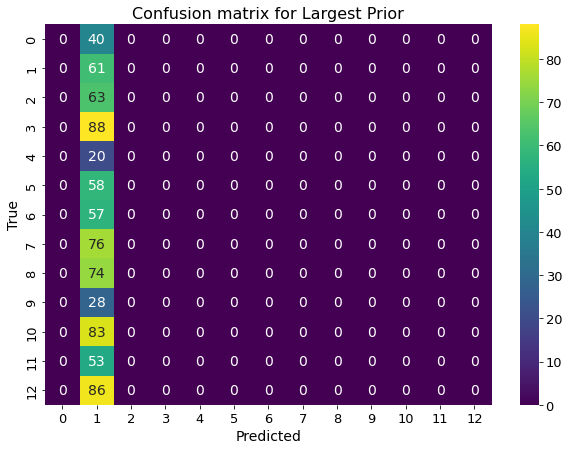

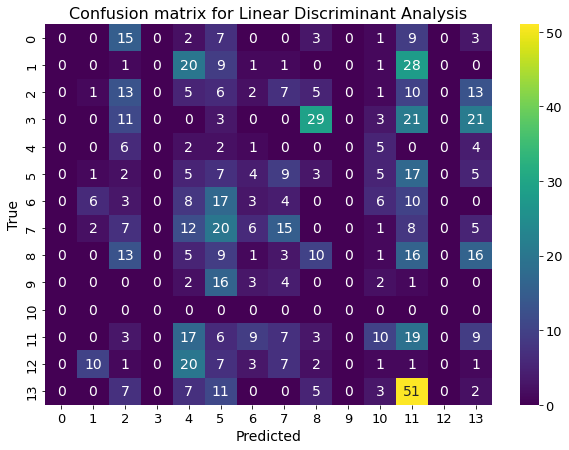

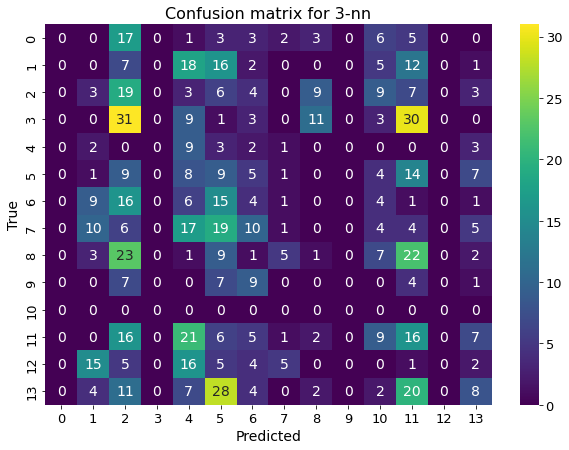

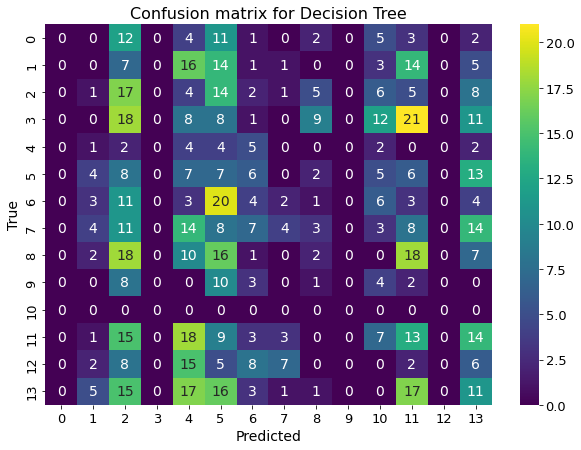

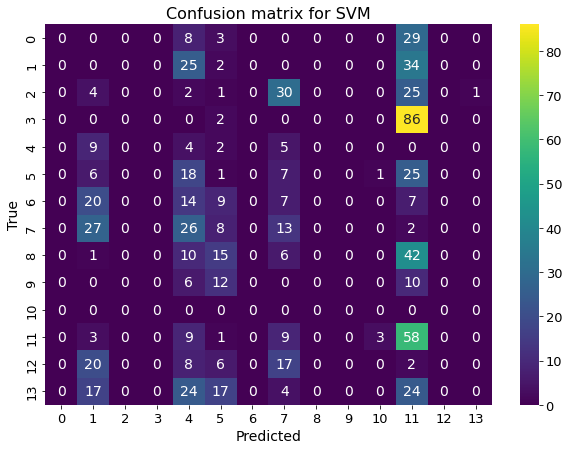

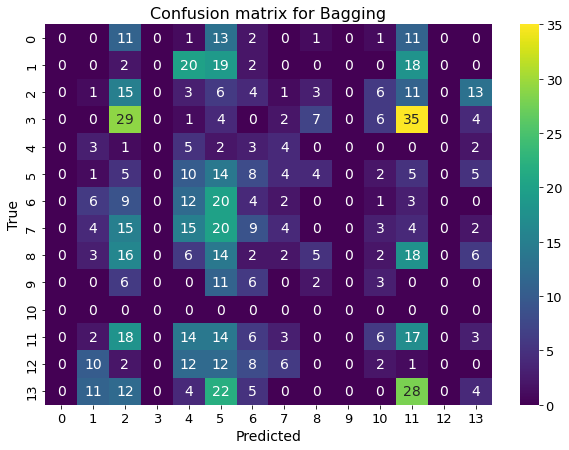

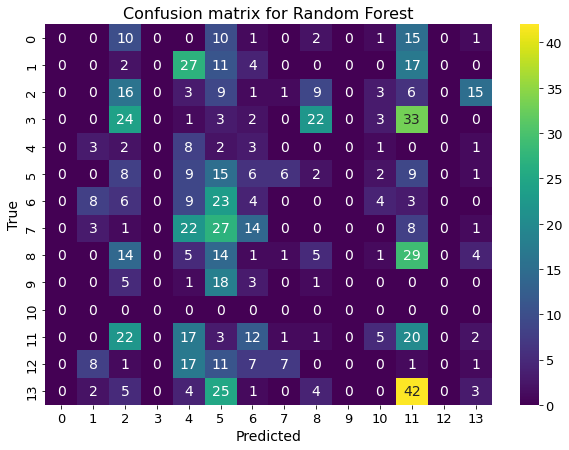


Results for video: Pigeons_4927_960_540_600f with feature: DataLBP

Largest Prior:
  Accuracy: 7.750952986022871%
  Precision: 0.6007727219153688%
  Recall: 7.750952986022871%
  F1 Score: 1.1151135192155546%

Linear Discriminant Analysis:
  Accuracy: 9.021601016518424%
  Precision: 7.84002564167436%
  Recall: 9.021601016518424%
  F1 Score: 7.888409165078148%

3-nn:
  Accuracy: 8.513341804320202%
  Precision: 6.477662625285251%
  Recall: 8.513341804320202%
  F1 Score: 6.209437578812696%

Decision Tree:
  Accuracy: 7.878017789072427%
  Precision: 7.218716880080647%
  Recall: 7.878017789072427%
  F1 Score: 6.416168727724853%

SVM:
  Accuracy: 9.6569250317662%
  Precision: 3.2184849344654696%
  Recall: 9.6569250317662%
  F1 Score: 4.532476081971305%

Bagging:
  Accuracy: 8.640406607369759%
  Precision: 7.894047597726024%
  Recall: 8.640406607369759%
  F1 Score: 6.738472162815623%

Random Forest:
  Accuracy: 9.021601016518424%
  Precision: 5.712028271261006%
  Recall: 9.021601016518424%
  

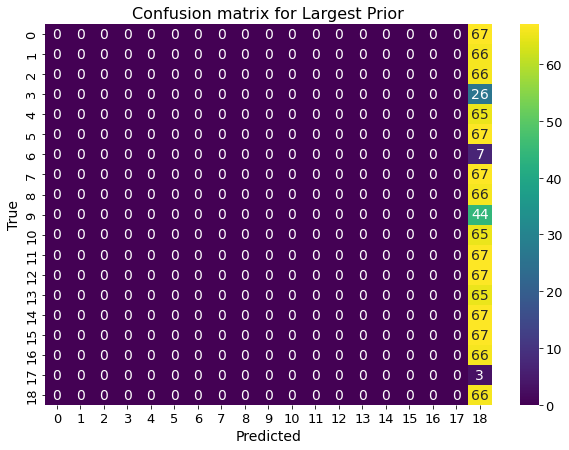

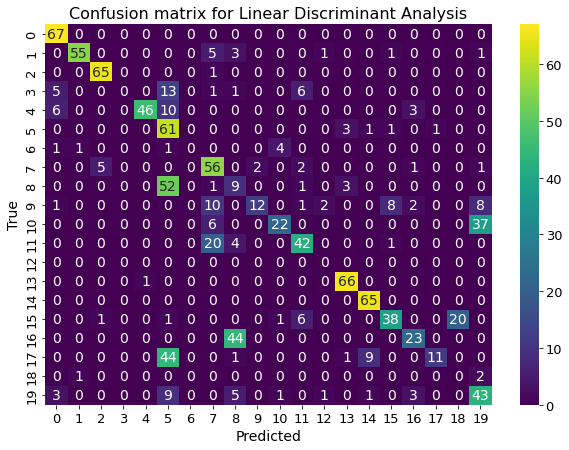

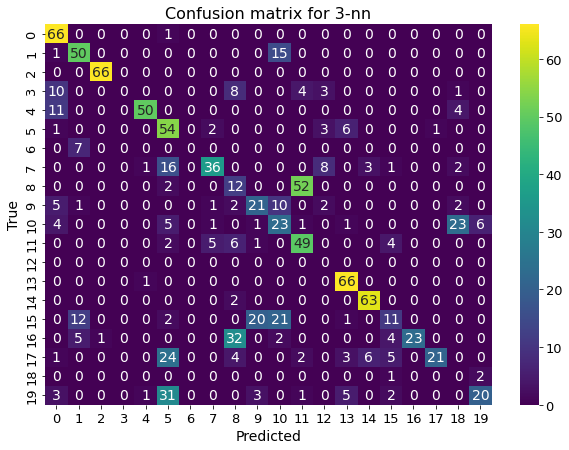

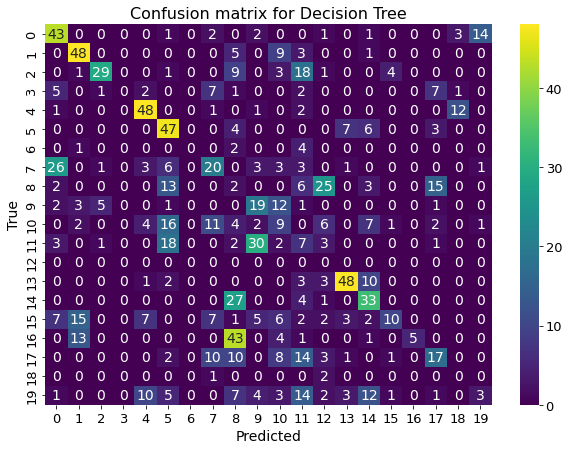

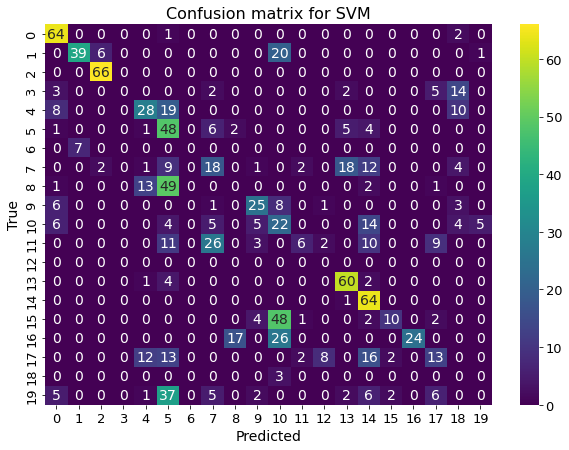

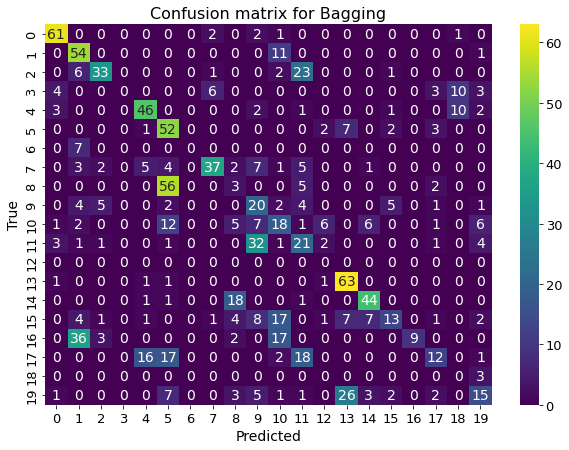

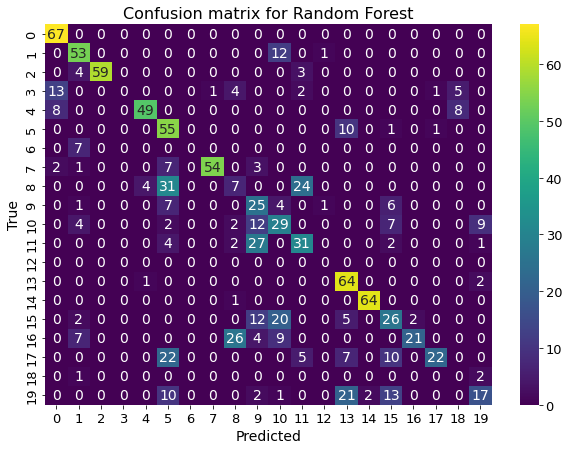


Results for video: Pigeons_29033_960_540_300f with feature: DataRGB

Largest Prior:
  Accuracy: 6.145251396648044%
  Precision: 0.3776411472800474%
  Recall: 6.145251396648044%
  F1 Score: 0.7115554248750366%

Linear Discriminant Analysis:
  Accuracy: 63.40782122905028%
  Precision: 70.25375651013891%
  Recall: 63.40782122905028%
  F1 Score: 62.113439708168336%

3-nn:
  Accuracy: 58.75232774674115%
  Precision: 64.3599679681756%
  Recall: 58.75232774674115%
  F1 Score: 57.59570820136657%

Decision Tree:
  Accuracy: 36.12662942271881%
  Precision: 43.16642195173361%
  Recall: 36.12662942271881%
  F1 Score: 35.324250676240176%

SVM:
  Accuracy: 45.344506517690874%
  Precision: 48.34228493759263%
  Recall: 45.344506517690874%
  F1 Score: 41.769584606787866%

Bagging:
  Accuracy: 46.64804469273743%
  Precision: 51.113611760891864%
  Recall: 46.64804469273743%
  F1 Score: 44.26678998663668%

Random Forest:
  Accuracy: 59.86964618249534%
  Precision: 63.302594298471895%
  Recall: 59.8696461

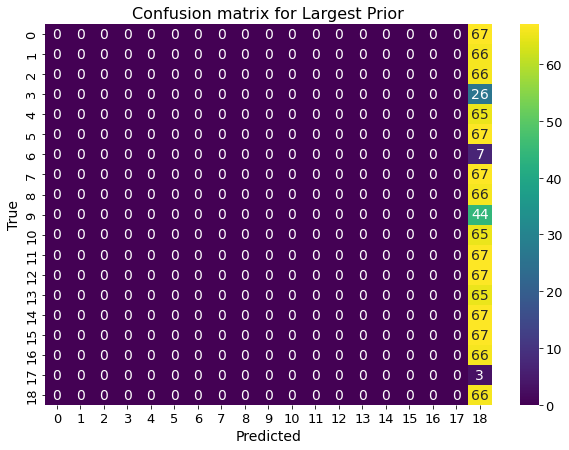

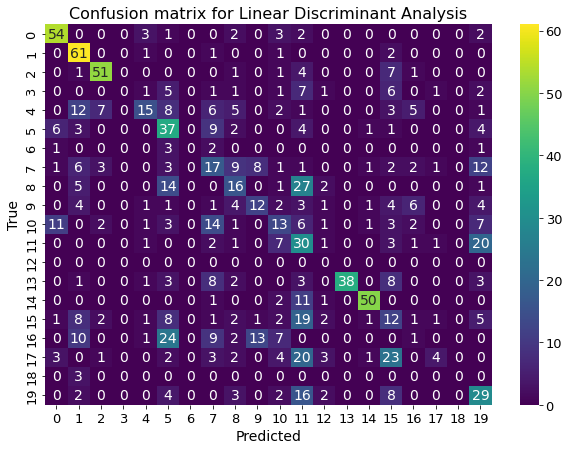

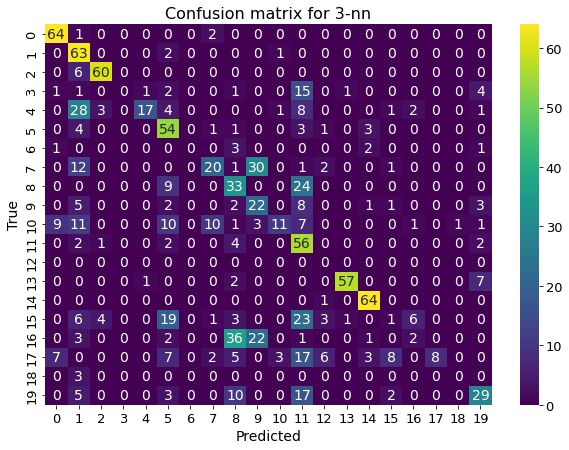

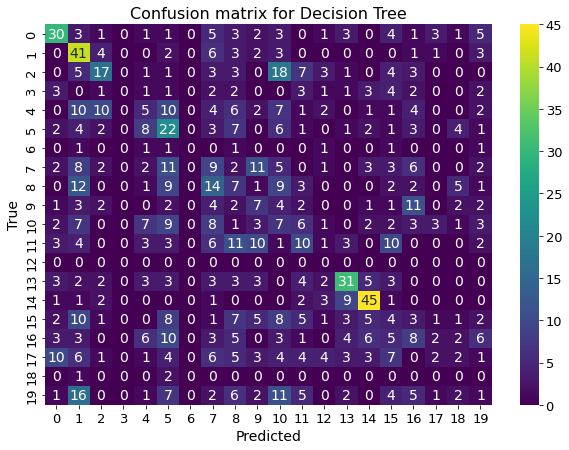

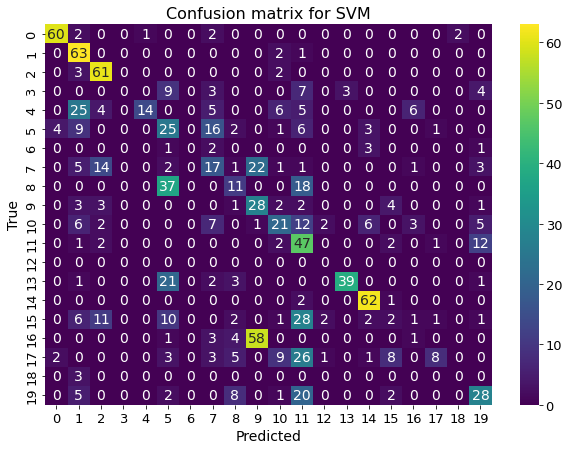

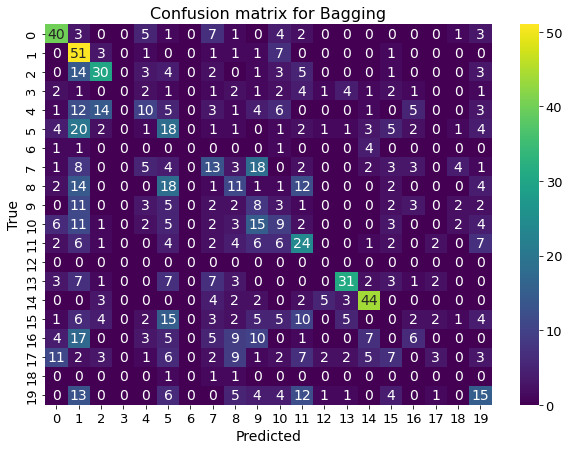

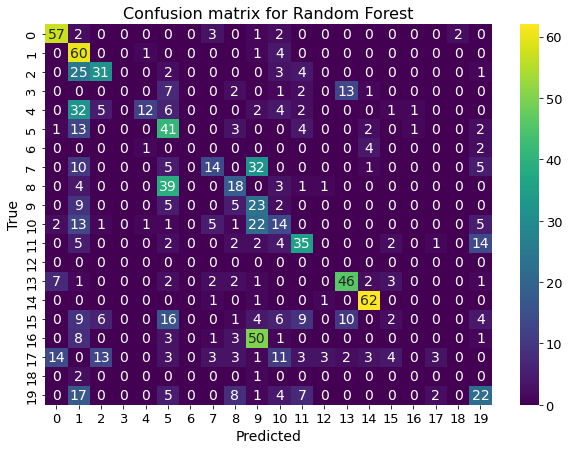


Results for video: Pigeons_29033_960_540_300f with feature: DataHOG

Largest Prior:
  Accuracy: 6.145251396648044%
  Precision: 0.3776411472800474%
  Recall: 6.145251396648044%
  F1 Score: 0.7115554248750366%

Linear Discriminant Analysis:
  Accuracy: 40.9683426443203%
  Precision: 43.28695783009647%
  Recall: 40.9683426443203%
  F1 Score: 39.14693479146768%

3-nn:
  Accuracy: 52.23463687150838%
  Precision: 56.61653869752037%
  Recall: 52.23463687150838%
  F1 Score: 47.52416270862801%

Decision Tree:
  Accuracy: 22.905027932960895%
  Precision: 21.918307945993973%
  Recall: 22.905027932960895%
  F1 Score: 21.525040563760303%

SVM:
  Accuracy: 45.344506517690874%
  Precision: 47.87694676276259%
  Recall: 45.344506517690874%
  F1 Score: 41.45905476501881%

Bagging:
  Accuracy: 29.14338919925512%
  Precision: 29.247215511107154%
  Recall: 29.14338919925512%
  F1 Score: 27.17312253438287%

Random Forest:
  Accuracy: 40.9683426443203%
  Precision: 42.45992104836261%
  Recall: 40.968342644

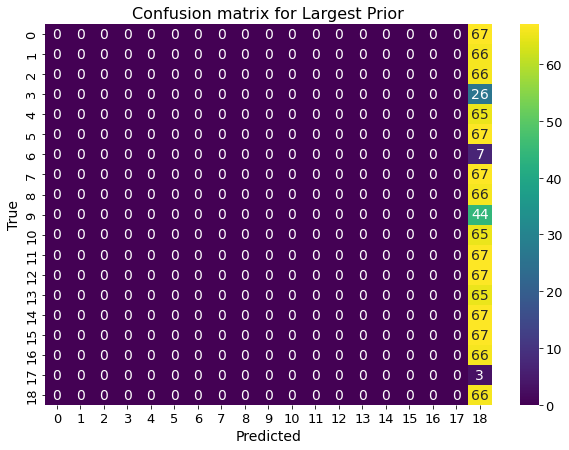

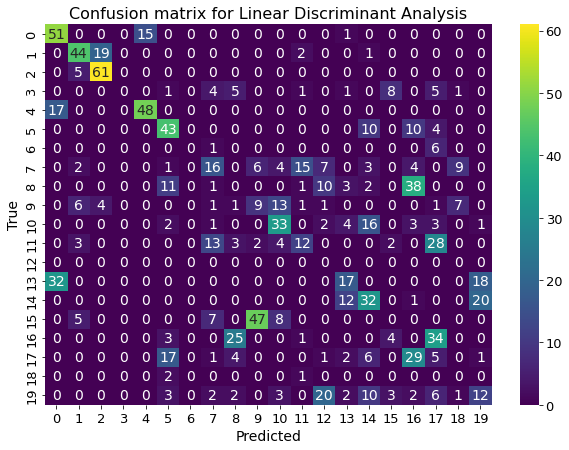

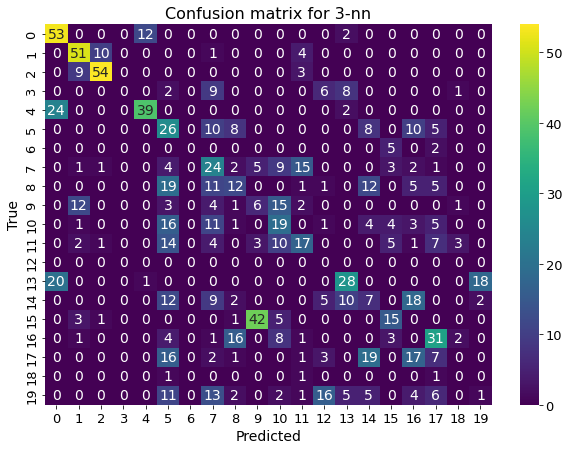

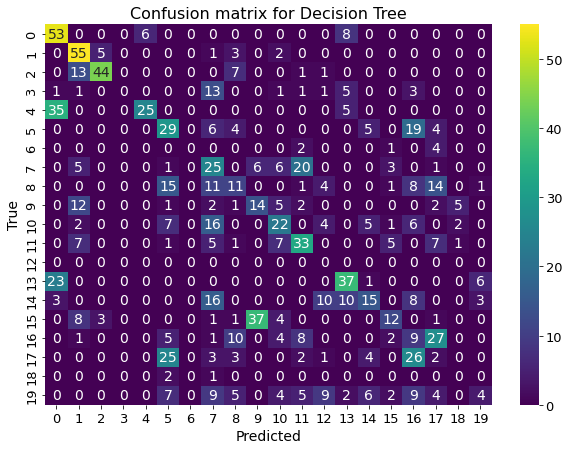

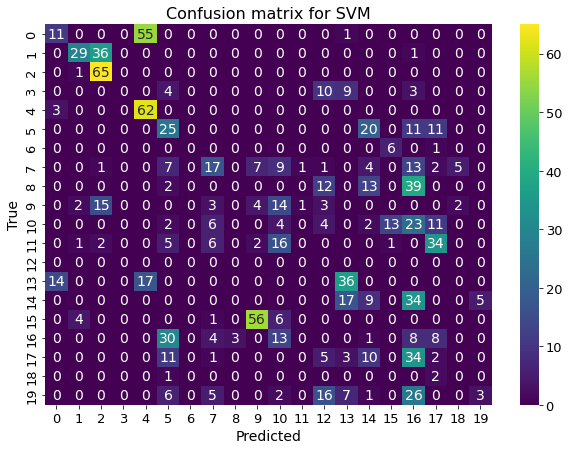

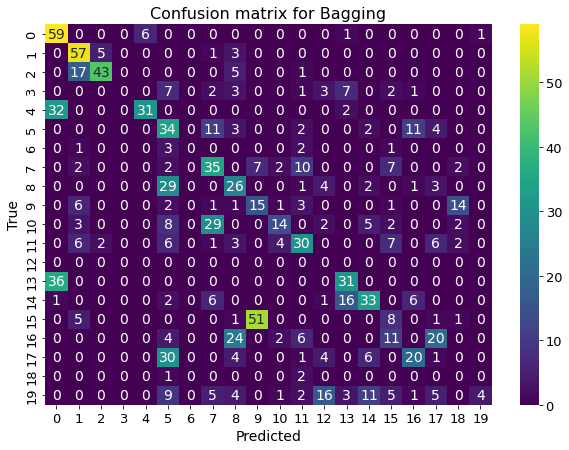

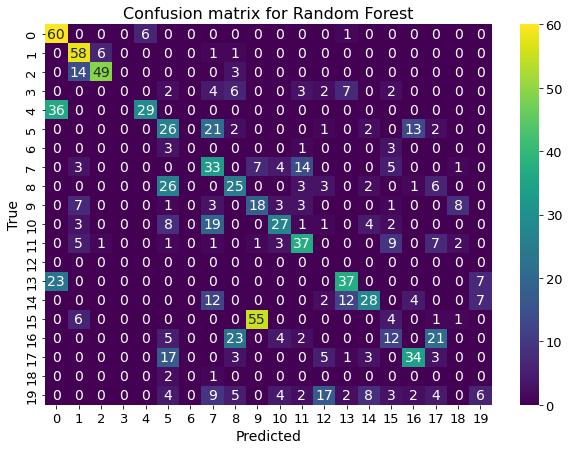


Results for video: Pigeons_29033_960_540_300f with feature: DataH10

Largest Prior:
  Accuracy: 6.145251396648044%
  Precision: 0.3776411472800474%
  Recall: 6.145251396648044%
  F1 Score: 0.7115554248750366%

Linear Discriminant Analysis:
  Accuracy: 35.66108007448789%
  Precision: 34.31936594377852%
  Recall: 35.66108007448789%
  F1 Score: 34.297224542421446%

3-nn:
  Accuracy: 33.42644320297951%
  Precision: 33.16316097249025%
  Recall: 33.42644320297951%
  F1 Score: 32.41063285392638%

Decision Tree:
  Accuracy: 36.312849162011176%
  Precision: 38.52956373266906%
  Recall: 36.312849162011176%
  F1 Score: 35.19058309590856%

SVM:
  Accuracy: 25.605214152700185%
  Precision: 24.905071903205656%
  Recall: 25.605214152700185%
  F1 Score: 22.6805278877228%

Bagging:
  Accuracy: 39.19925512104283%
  Precision: 43.11745425292407%
  Recall: 39.19925512104283%
  F1 Score: 37.23869185079208%

Random Forest:
  Accuracy: 40.9683426443203%
  Precision: 41.55864608572064%
  Recall: 40.968342644

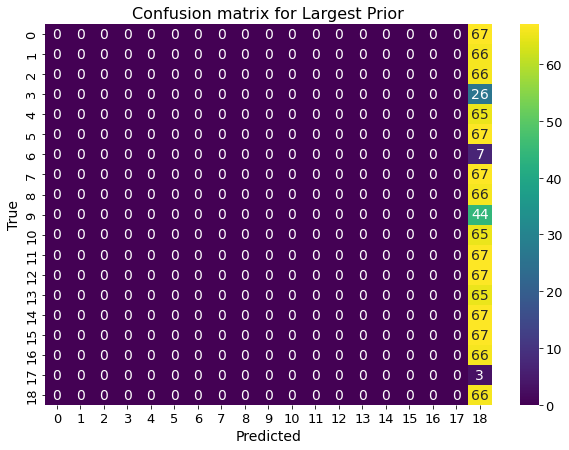

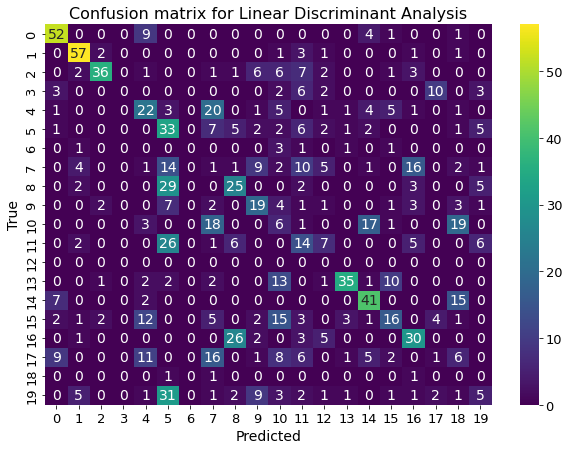

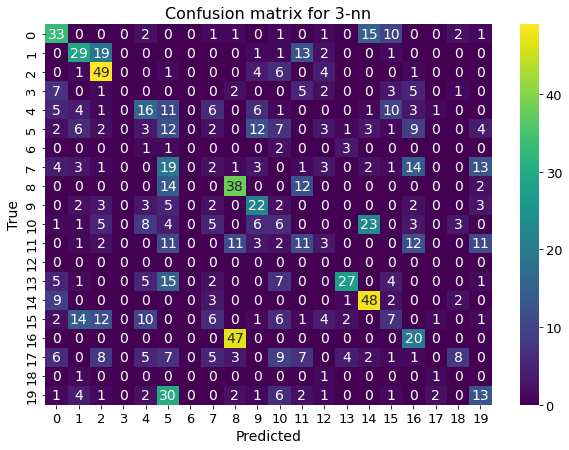

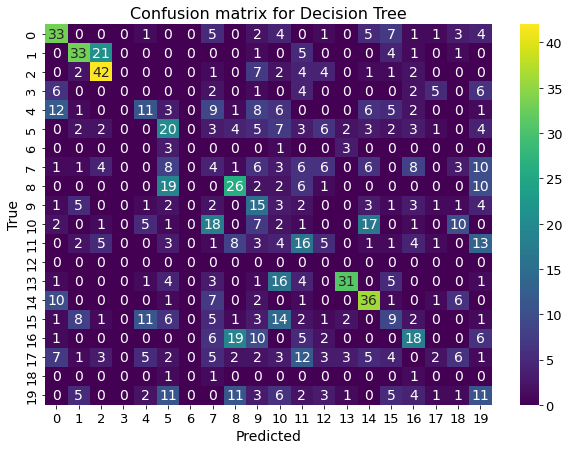

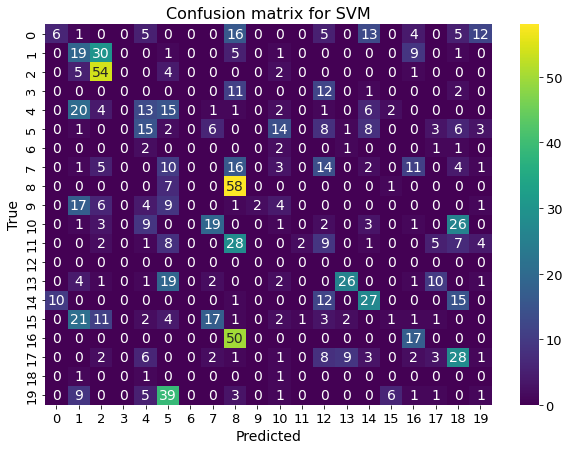

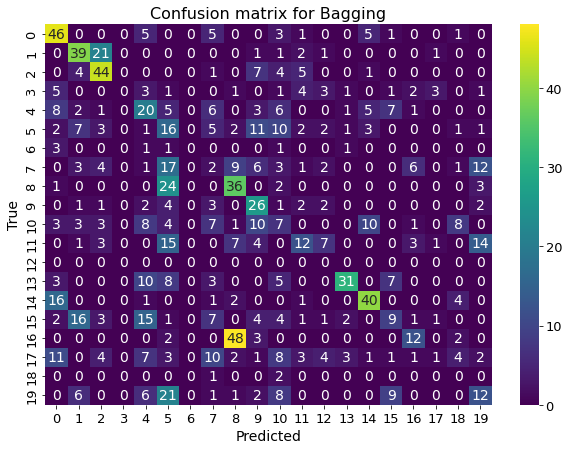

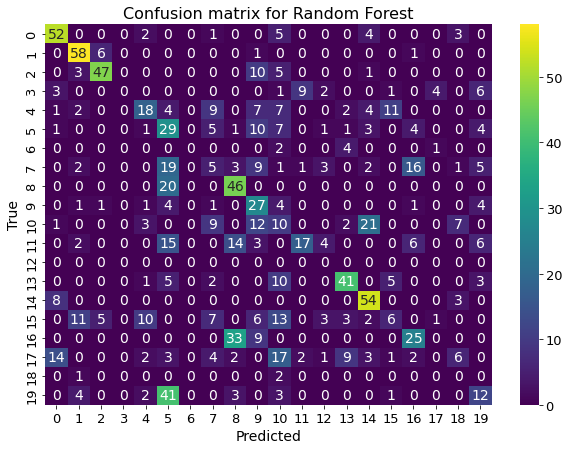


Results for video: Pigeons_29033_960_540_300f with feature: DataLBP

Largest Prior:
  Accuracy: 6.145251396648044%
  Precision: 0.3776411472800474%
  Recall: 6.145251396648044%
  F1 Score: 0.7115554248750366%

Linear Discriminant Analysis:
  Accuracy: 36.592178770949715%
  Precision: 38.80011026227322%
  Recall: 36.592178770949715%
  F1 Score: 36.55573710206844%

3-nn:
  Accuracy: 31.00558659217877%
  Precision: 28.72410572699975%
  Recall: 31.00558659217877%
  F1 Score: 28.859662332242507%

Decision Tree:
  Accuracy: 28.77094972067039%
  Precision: 30.053660662135396%
  Recall: 28.77094972067039%
  F1 Score: 28.576487558082174%

SVM:
  Accuracy: 21.601489757914337%
  Precision: 28.504146983836403%
  Recall: 21.601489757914337%
  F1 Score: 19.012364023810104%

Bagging:
  Accuracy: 32.86778398510242%
  Precision: 33.09312635535841%
  Recall: 32.86778398510242%
  F1 Score: 31.055474863597777%

Random Forest:
  Accuracy: 41.62011173184357%
  Precision: 40.01382883162922%
  Recall: 41.620

In [108]:
def calculate_results(X_train, y_train, X_test, y_test):
    results = {}
    for classifier_name, classifier in classifiers.items():
        if classifier_name == 'Largest Prior':
            y_pred = [largest_prior(y_train)] * len(y_test)
        else:
            classifier.fit(X_train, y_train)
            y_pred = classifier.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        
        results[classifier_name] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}

        # Plot confusion matrix for each classifier
        plot_confusion_matrix(y_test, y_pred, f'Confusion matrix for {classifier_name}')
        
    return results
# # Create results directory if it doesn't exist
if not os.path.exists(results_directory):
    os.makedirs(results_directory)

for video_name, sizes in videos.items():
    training_size = sizes[0] // 2  # Use the first half of the video for training
    testing_size = sizes[0] - training_size  # Use the remaining half of the video for testing

    print("\n" + "="*50)  # Print line separator
    print(f"Processing video: {video_name}")
    print("="*50)
    
    for feature in ['DataRGB', 'DataHOG', 'DataH10', 'DataLBP']:
        print(f"\nProcessing feature: {feature}")
        X_train, y_train, X_test, y_test = load_data_sampling(video_name, feature, directory_path, training_size, testing_size)
        results = calculate_results(X_train, y_train, X_test, y_test)
        print_results(video_name, feature, results)

The Above plots for all models, for all features and for all animals

In [120]:
def plot_confusion_matrix(y_true, y_pred, title, results_directory, video_name, feature, classifier_name):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Print confusion matrix as text
    print(f'Confusion Matrix for {classifier_name}:\n{cm}\n')

    # Plot the confusion matrix
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Save the figure
    fig_path = f"{results_directory}/{video_name}_{feature}_{classifier_name}_confusion_matrix.png"
    plt.savefig(fig_path)
    print(f"Confusion matrix saved to {fig_path}")

    # Show the figure
    plt.show()



Processing video: Pigeons_29033_960_540_300f

Processing feature: DataRGB


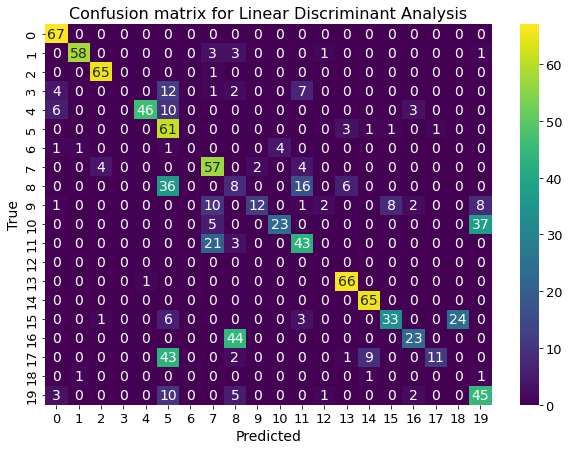

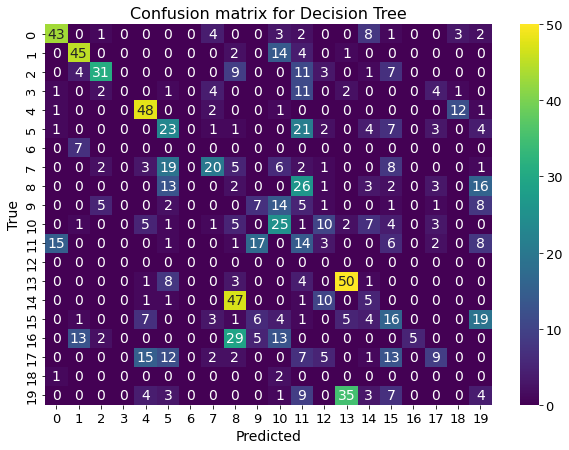

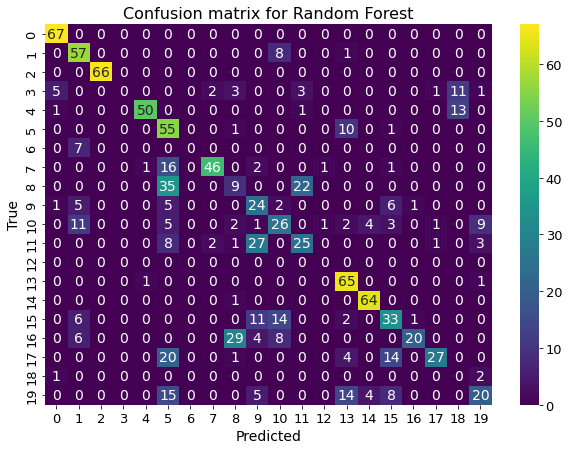


Results for video: Pigeons_29033_960_540_300f with feature: DataRGB

Largest Prior:
  Accuracy: 6.145251396648044%
  Precision: 0.3776411472800474%
  Recall: 6.145251396648044%
  F1 Score: 0.7115554248750366%

Linear Discriminant Analysis:
  Accuracy: 63.59404096834265%
  Precision: 70.3644843405714%
  Recall: 63.59404096834265%
  F1 Score: 62.09088760952653%

3-nn:
  Accuracy: 58.659217877094974%
  Precision: 64.2164882887602%
  Recall: 58.659217877094974%
  F1 Score: 57.65851081248241%

Decision Tree:
  Accuracy: 32.30912476722533%
  Precision: 39.009781421416456%
  Recall: 32.30912476722533%
  F1 Score: 32.085861789515945%

SVM:
  Accuracy: 46.18249534450652%
  Precision: 49.535665835564025%
  Recall: 46.18249534450652%
  F1 Score: 42.904628747350046%

Bagging:
  Accuracy: 48.13780260707635%
  Precision: 50.40781053588401%
  Recall: 48.13780260707635%
  F1 Score: 44.93147108556982%

Random Forest:
  Accuracy: 60.893854748603346%
  Precision: 64.77119977707868%
  Recall: 60.89385474

In [127]:
def calculate_results(X_train, y_train, X_test, y_test, results_directory, video_name, feature):
    results = {}
    for classifier_name, classifier in classifiers.items():
        if classifier_name == 'Largest Prior':
            y_pred = [largest_prior(y_train)] * len(y_test)
        else:
            classifier.fit(X_train, y_train)
            y_pred = classifier.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        
        results[classifier_name] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}

        # Plot confusion matrix for specific classifiers
        if classifier_name in ['Linear Discriminant Analysis', 'Random Forest', 'Decision Tree']:
            plot_confusion_matrix(y_test, y_pred, f'Confusion matrix for {classifier_name}', results_directory, video_name, feature, classifier_name)
        
    return results

# # Create results directory if it doesn't exist
if not os.path.exists(results_directory):
    os.makedirs(results_directory)

for video_name, sizes in videos.items():
    # Add a check for the specific video
    if video_name == 'Pigeons_29033_960_540_300f':
        training_size = sizes[0] // 2  # Use the first half of the video for training
        testing_size = sizes[0] - training_size  # Use the remaining half of the video for testing

        print("\n" + "="*50)  # Print line separator
        print(f"Processing video: {video_name}")
        print("="*50)
        
        # Add a check for the specific feature
        if 'DataRGB' in ['DataRGB', 'DataHOG', 'DataH10', 'DataLBP']:
            print(f"\nProcessing feature: DataRGB")
            X_train, y_train, X_test, y_test = load_data_sampling(video_name, 'DataRGB', directory_path, training_size, testing_size)
            results = calculate_results(X_train, y_train, X_test, y_test, results_directory, video_name, 'DataRGB')
            print_results(video_name, 'DataRGB', results)


The Above plots for only Linear Discriminant Analysis, Random Forest, and Decision Trees.

## 4. Make a Prediction of Labels
An example with Random Forest Classifier.

In [85]:
np.random.seed(42)
# Select the video and feature for prediction
video_name = 'Pigeons_29033_960_540_300f'
feature = 'DataRGB'

# Load the data for prediction
X_train, y_train, X_test, y_test = load_data_sampling(video_name, feature, directory_path, training_size, testing_size)

# Choose the classifier for prediction
classifier_name = 'Random Forest'
classifier = classifiers[classifier_name]

# Train the classifier on the entire training data
classifier.fit(X_train, y_train)

# Perform prediction on the test data
y_pred = classifier.predict(X_test)

# Evaluate the accuracy of the prediction
accuracy = accuracy_score(y_test, y_pred)

# Print the results
print(f"\nPrediction results for video: {video_name} with feature: {feature}")
print(f"\nClassifier: {classifier_name}")
print(f"Accuracy: {accuracy * 100}%")
print(f"\nPredicted labels: {y_pred}")
unique_labels = np.unique(y_pred)
print(f"Unique labels in y_pred: {unique_labels}")


Prediction results for video: Pigeons_29033_960_540_300f with feature: DataRGB

Classifier: Random Forest
Accuracy: 60.80074487895717%

Predicted labels: [ 0  7 11 ... 10  5 13]
Unique labels in y_pred: [ 0  1  2  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [87]:
np.random.seed(42)
# Select the video and feature for prediction
video_name = 'Pigeons_29033_960_540_300f'
feature = 'DataRGB'

# Load the data for prediction
X_train, y_train, X_test, y_test = load_data_sampling(video_name, feature, directory_path, training_size, testing_size)

# Choose the classifier for prediction
classifier_name = 'Linear Discriminant Analysis'
classifier = classifiers[classifier_name]

# Train the classifier on the entire training data
classifier.fit(X_train, y_train)

# Perform prediction on the test data
y_pred = classifier.predict(X_test)

# Evaluate the accuracy of the prediction
accuracy = accuracy_score(y_test, y_pred)

# Print the results
print(f"\nPrediction results for video: {video_name} with feature: {feature}")
print(f"\nClassifier: {classifier_name}")
print(f"Accuracy: {accuracy * 100}%")
print(f"\nPredicted labels: {y_pred}")
unique_labels = np.unique(y_pred)
print(f"Unique labels in y_pred: {unique_labels}")


Prediction results for video: Pigeons_29033_960_540_300f with feature: DataRGB

Classifier: Linear Discriminant Analysis
Accuracy: 63.96648044692738%

Predicted labels: [ 0  7 11 ... 18  5 13]
Unique labels in y_pred: [ 0  1  2  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [96]:
np.random.seed(42)
# Select the video and feature for prediction
video_name = 'Pigeons_29033_960_540_300f'
feature = 'DataRGB'

# Load the data for prediction
X_train, y_train, X_test, y_test = load_data_sampling(video_name, feature, directory_path, training_size, testing_size)

# Choose the classifier for prediction
classifier_name = 'Decision Tree'
classifier = classifiers[classifier_name]

# Train the classifier on the entire training data
classifier.fit(X_train, y_train)

# Perform prediction on the test data
y_pred = classifier.predict(X_test)

# Evaluate the accuracy of the prediction
accuracy = accuracy_score(y_test, y_pred)

# Print the results
print(f"\nPrediction results for video: {video_name} with feature: {feature}")
print(f"\nClassifier: {classifier_name}")
print(f"Accuracy: {accuracy * 100}%")
print(f"\nPredicted labels: {y_pred}")
unique_labels = np.unique(y_pred)
print(f"Unique labels in y_pred: {unique_labels}")


Prediction results for video: Pigeons_29033_960_540_300f with feature: DataRGB

Classifier: Decision Tree
Accuracy: 38.08193668528864%

Predicted labels: [ 0 19 11 ... 19 11  5]
Unique labels in y_pred: [ 0  1  2  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19]


## 5. Further Metrics
Cross validation fold 2,3,5,7 and 10

Linear Discriminant Analysis:
  Training size: 74
  Training score: 1.0
  Validation score: 0.1927710843373494

  Training size: 242
  Training score: 0.9876033057851239
  Validation score: 0.3005354752342704

  Training size: 410
  Training score: 0.9646341463414634
  Validation score: 0.3594377510040161

  Training size: 578
  Training score: 0.8970588235294117
  Validation score: 0.4598393574297188

  Training size: 747
  Training score: 0.8755020080321285
  Validation score: 0.5983935742971888

3-nn:
  Training size: 74
  Training score: 0.918918918918919
  Validation score: 0.19210174029451138

  Training size: 242
  Training score: 0.9380165289256199
  Validation score: 0.2282463186077644

  Training size: 410
  Training score: 0.924390243902439
  Validation score: 0.29718875502008035

  Training size: 578
  Training score: 0.9005190311418685
  Validation score: 0.43708165997322623

  Training size: 747
  Training score: 0.9022757697456493
  Validation score: 0.5870147255689424



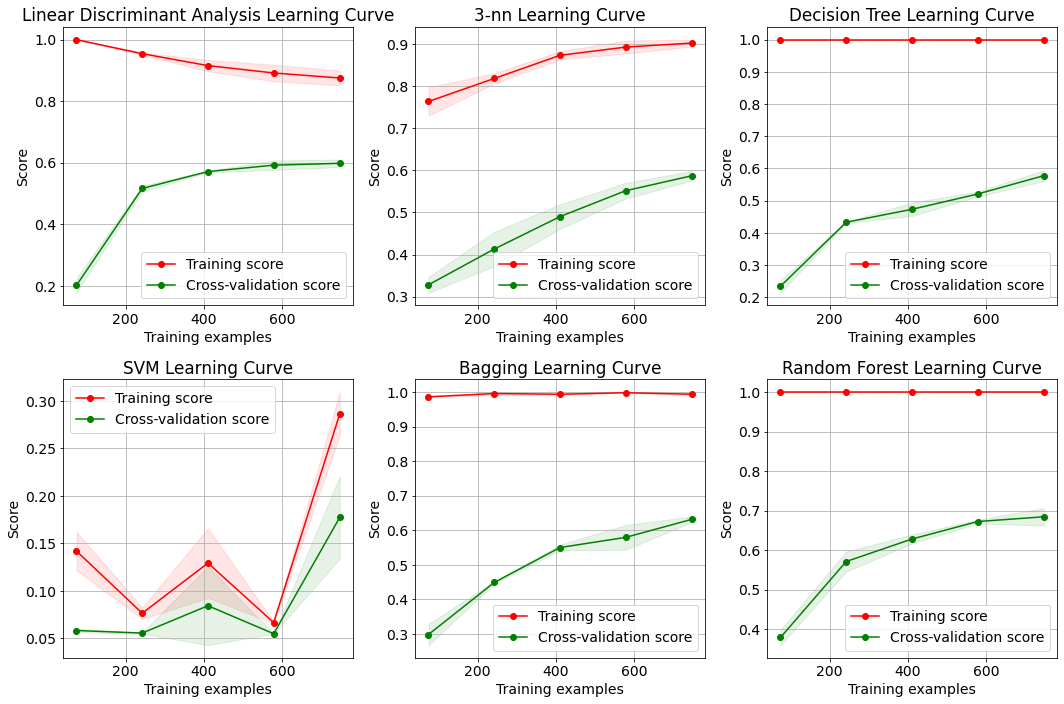

In [73]:
from sklearn.model_selection import learning_curve
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # creating a subplot of 2x3

# We make a list of axes
axes = axes.flatten()

i = 0
for classifier_name, classifier in classifiers.items():
    if classifier is not None:  # Skip 'Largest Prior'
        skplt.estimators.plot_learning_curve(classifier, X_train, y_train,
                                             cv=2, shuffle=True, scoring="accuracy",
                                             n_jobs=-1, ax=axes[i],
                                             title=f"{classifier_name} Learning Curve")
        train_sizes, train_scores, test_scores = learning_curve(classifier, X_train, y_train, cv=2)
        print(f"{classifier_name}:")
        for train_size, train_score, test_score in zip(train_sizes, train_scores, test_scores):
            print(f"  Training size: {train_size}")
            print(f"  Training score: {train_score.mean()}")
            print(f"  Validation score: {test_score.mean()}\n")
        i += 1
plt.tight_layout()
plt.savefig('learningcurve2.png',dpi = 800)
plt.show()


Linear Discriminant Analysis:
  Training size: 99
  Training score: 1.0
  Validation score: 0.24364123159303883

  Training size: 323
  Training score: 0.9793601651186791
  Validation score: 0.3908969210174029

  Training size: 547
  Training score: 0.9073735527117611
  Validation score: 0.4618473895582329

  Training size: 771
  Training score: 0.8534370946822308
  Validation score: 0.5769745649263722

  Training size: 996
  Training score: 0.8400267737617136
  Validation score: 0.6298527443105756

3-nn:
  Training size: 99
  Training score: 0.9831649831649831
  Validation score: 0.19812583668005354

  Training size: 323
  Training score: 0.937048503611971
  Validation score: 0.3293172690763052

  Training size: 547
  Training score: 0.9031078610603291
  Validation score: 0.4404283801874163

  Training size: 771
  Training score: 0.8958063121487245
  Validation score: 0.5669344042838018

  Training size: 996
  Training score: 0.9193440428380187
  Validation score: 0.6726907630522089



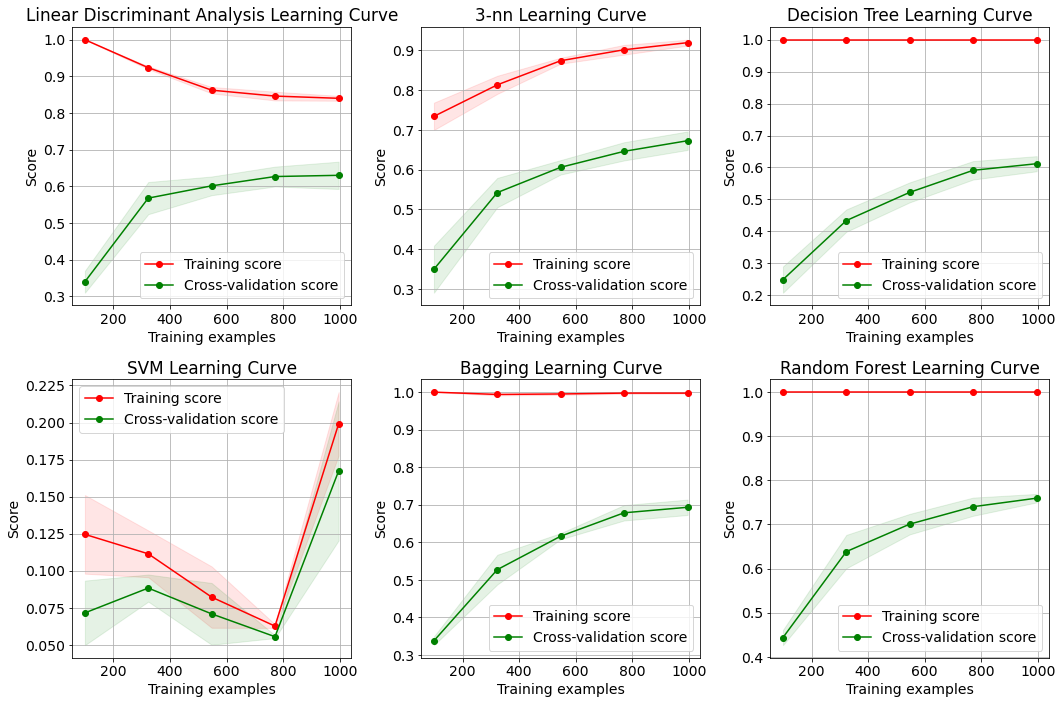

In [74]:
from sklearn.model_selection import learning_curve


plt.rcParams.update({'font.size': 14,
                     'axes.titlesize': 16,
                     'axes.labelsize': 14,
                     'xtick.labelsize': 12,
                     'ytick.labelsize': 12,
                     'legend.fontsize': 12})
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # creating a subplot of 2x3

# We make a list of axes
axes = axes.flatten()

i = 0
for classifier_name, classifier in classifiers.items():
    if classifier is not None:  # Skip 'Largest Prior'
        skplt.estimators.plot_learning_curve(classifier, X_train, y_train,
                                             cv=3, shuffle=True, scoring="accuracy",
                                             n_jobs=-1, ax=axes[i],
                                             title=f"{classifier_name} Learning Curve")
        train_sizes, train_scores, test_scores = learning_curve(classifier, X_train, y_train, cv=3)
        print(f"{classifier_name}:")
        for train_size, train_score, test_score in zip(train_sizes, train_scores, test_scores):
            print(f"  Training size: {train_size}")
            print(f"  Training score: {train_score.mean()}")
            print(f"  Validation score: {test_score.mean()}\n")
        i += 1
plt.tight_layout()
plt.savefig('learningcurve3.png',dpi = 800)
plt.show()


Linear Discriminant Analysis:
  Training size: 119
  Training score: 1.0
  Validation score: 0.28909339857691185

  Training size: 388
  Training score: 0.9706185567010308
  Validation score: 0.44174092612960425

  Training size: 657
  Training score: 0.8831050228310502
  Validation score: 0.5314067024309219

  Training size: 926
  Training score: 0.8291576673866091
  Validation score: 0.6278534713025521

  Training size: 1195
  Training score: 0.8217573221757322
  Validation score: 0.6713429552647528

3-nn:
  Training size: 119
  Training score: 0.9747899159663864
  Validation score: 0.23755695719512468

  Training size: 388
  Training score: 0.934020618556701
  Validation score: 0.35605036923974775

  Training size: 657
  Training score: 0.8989345509893456
  Validation score: 0.4838993513052457

  Training size: 926
  Training score: 0.8902807775377971
  Validation score: 0.6399362528338309

  Training size: 1195
  Training score: 0.9246861924686194
  Validation score: 0.726246324437

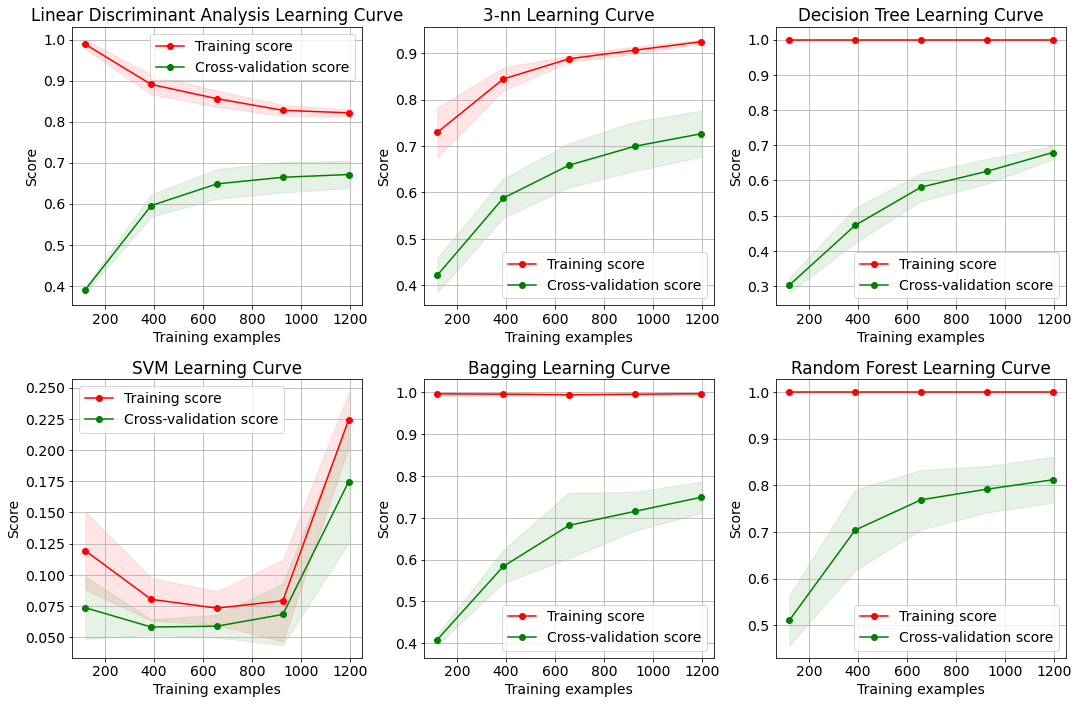

In [76]:
from sklearn.model_selection import learning_curve


plt.rcParams.update({'font.size': 14,
                     'axes.titlesize': 16,
                     'axes.labelsize': 14,
                     'xtick.labelsize': 12,
                     'ytick.labelsize': 12,
                     'legend.fontsize': 12})
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # creating a subplot of 2x3

# We make a list of axes
axes = axes.flatten()

i = 0
for classifier_name, classifier in classifiers.items():
    if classifier is not None:  # Skip 'Largest Prior'
        skplt.estimators.plot_learning_curve(classifier, X_train, y_train,
                                             cv=5, shuffle=True, scoring="accuracy",
                                             n_jobs=-1, ax=axes[i],
                                             title=f"{classifier_name} Learning Curve")
        train_sizes, train_scores, test_scores = learning_curve(classifier, X_train, y_train, cv=5)
        print(f"{classifier_name}:")
        for train_size, train_score, test_score in zip(train_sizes, train_scores, test_scores):
            print(f"  Training size: {train_size}")
            print(f"  Training score: {train_score.mean()}")
            print(f"  Validation score: {test_score.mean()}\n")
        i += 1
plt.tight_layout()
plt.savefig('learningcurve5.png',dpi = 800)
plt.show()


Linear Discriminant Analysis:
  Training size: 128
  Training score: 0.9988839285714286
  Validation score: 0.3083015225308236

  Training size: 416
  Training score: 0.9690934065934064
  Validation score: 0.46436563305064027

  Training size: 704
  Training score: 0.8766233766233766
  Validation score: 0.5468355303158515

  Training size: 992
  Training score: 0.8204205069124425
  Validation score: 0.6519960886816225

  Training size: 1280
  Training score: 0.8184151785714285
  Validation score: 0.6880598231131335

3-nn:
  Training size: 128
  Training score: 0.96875
  Validation score: 0.25813134257256937

  Training size: 416
  Training score: 0.9378434065934064
  Validation score: 0.3759660768348408

  Training size: 704
  Training score: 0.8967126623376623
  Validation score: 0.5006111434964929

  Training size: 992
  Training score: 0.8888248847926266
  Validation score: 0.6580166356393816

  Training size: 1280
  Training score: 0.927232142857143
  Validation score: 0.7435735910

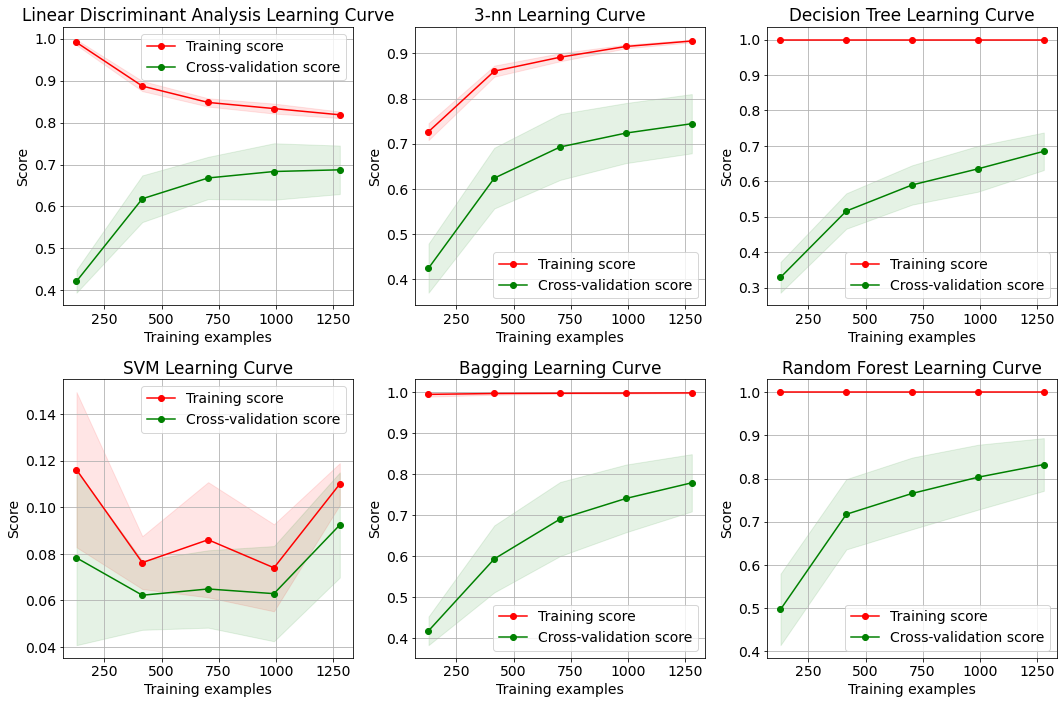

In [77]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # creating a subplot of 2x3

# We make a list of axes
axes = axes.flatten()

i = 0
for classifier_name, classifier in classifiers.items():
    if classifier is not None:  # Skip 'Largest Prior'
        skplt.estimators.plot_learning_curve(classifier, X_train, y_train,
                                             cv=7, shuffle=True, scoring="accuracy",
                                             n_jobs=-1, ax=axes[i],
                                             title=f"{classifier_name} Learning Curve")
        train_sizes, train_scores, test_scores = learning_curve(classifier, X_train, y_train, cv=7)
        print(f"{classifier_name}:")
        for train_size, train_score, test_score in zip(train_sizes, train_scores, test_scores):
            print(f"  Training size: {train_size}")
            print(f"  Training score: {train_score.mean()}")
            print(f"  Validation score: {test_score.mean()}\n")
        i += 1
plt.tight_layout()
plt.savefig('learningcurve.png',dpi = 800)
plt.show()


Linear Discriminant Analysis:
  Training size: 134
  Training score: 0.9992537313432835
  Validation score: 0.33894407158836687

  Training size: 436
  Training score: 0.9713302752293579
  Validation score: 0.4776957494407159

  Training size: 739
  Training score: 0.8687415426251691
  Validation score: 0.5889888143176735

  Training size: 1041
  Training score: 0.8136407300672431
  Validation score: 0.676765100671141

  Training size: 1344
  Training score: 0.8123511904761905
  Validation score: 0.7041118568232663

3-nn:
  Training size: 134
  Training score: 0.967910447761194
  Validation score: 0.2740626398210291

  Training size: 436
  Training score: 0.938532110091743
  Validation score: 0.3966129753914989

  Training size: 739
  Training score: 0.8959404600811908
  Validation score: 0.5501879194630873

  Training size: 1041
  Training score: 0.8875120076849183
  Validation score: 0.6848232662192394

  Training size: 1344
  Training score: 0.9279761904761905
  Validation score: 0.

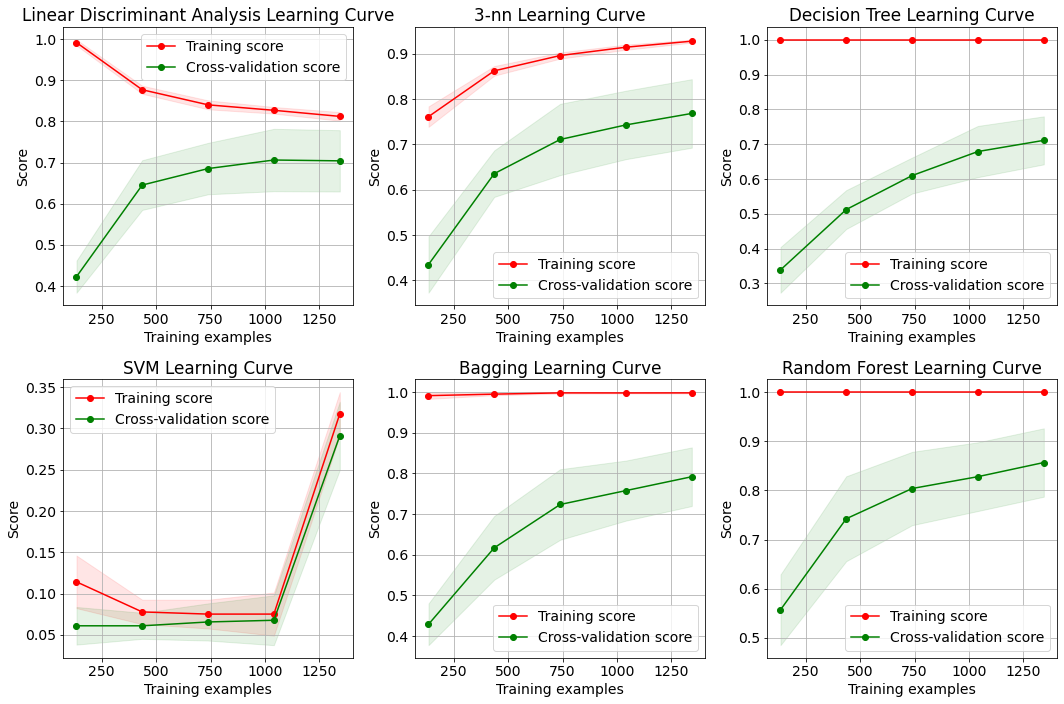

In [78]:
from sklearn.model_selection import learning_curve


plt.rcParams.update({'font.size': 14,
                     'axes.titlesize': 16,
                     'axes.labelsize': 14,
                     'xtick.labelsize': 12,
                     'ytick.labelsize': 12,
                     'legend.fontsize': 12})
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # creating a subplot of 2x3

# We make a list of axes
axes = axes.flatten()

i = 0
for classifier_name, classifier in classifiers.items():
    if classifier is not None:  # Skip 'Largest Prior'
        skplt.estimators.plot_learning_curve(classifier, X_train, y_train,
                                             cv=10, shuffle=True, scoring="accuracy",
                                             n_jobs=-1, ax=axes[i],
                                             title=f"{classifier_name} Learning Curve")
        train_sizes, train_scores, test_scores = learning_curve(classifier, X_train, y_train, cv=10)
        print(f"{classifier_name}:")
        for train_size, train_score, test_score in zip(train_sizes, train_scores, test_scores):
            print(f"  Training size: {train_size}")
            print(f"  Training score: {train_score.mean()}")
            print(f"  Validation score: {test_score.mean()}\n")
        i += 1
plt.tight_layout()
plt.savefig('learningcurve10.png',dpi = 800)
plt.show()


## Save Results of cv training to CSV

In [80]:
import pandas as pd
from sklearn.model_selection import learning_curve
import numpy as np

# Create a dictionary of classifiers
classifiers = {
    'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
    '3-nn': KNeighborsClassifier(n_neighbors=3),
    'Decision Tree': DecisionTreeClassifier(),
    'SVM': SVC(kernel='linear'),
    'Bagging': BaggingClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=100)
}


# Define the list of cv values
cv_values = [2, 3, 5, 7, 10]

# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Classifier', 'CV', 'Training Size', 'Training Score', 'Validation Score'])

# Perform cross-validation for each cv value and classifier
for cv in cv_values:
    for classifier_name, classifier in classifiers.items():
        if classifier is not None:
            train_sizes, train_scores, test_scores = learning_curve(classifier, X_train, y_train, cv=cv)
            for train_size, train_score, test_score in zip(train_sizes, train_scores, test_scores):
                results_df = results_df.append({
                    'Classifier': classifier_name,
                    'CV': cv,
                    'Training Size': train_size,
                    'Training Score': np.mean(train_score),
                    'Validation Score': np.mean(test_score)
                }, ignore_index=True)

# Save the results to a CSV file
results_df.to_csv('cross_validation_results.csv', index=False)
